# Project: Diagnostic reasoning assistant

**Author:** Julia Parnis 
**Date:** February 7, 2026  
**Project:** Data Science Bootcamp - Final Projec

## Project Overview

**Goal:** Build an AI-powered diagnostic assistant that provides ranked differential diagnoses through iterative questioning, with enhanced detection of rare and overlooked conditions.

**Key Innovation:** Two-tier ML architecture combined with RAG (Retrieval-Augmented Generation) for transparent clinical reasoning and literature-backed rare disease identification.

**Dataset:** DDXPlus - 1.3M synthetic patient cases, 49 pathologies  
**Source:** [Hugging Face](https://huggingface.co/datasets/aai530-group6/ddxplus)
**Citation:** Fansi Tchango et al. (2022)

**Note:** This is a synthetic dataset (computer-generated from medical knowledge bases) designed for research and education. It provides a robust, privacy-compliant foundation for developing diagnostic AI systems.

# Notebook 1: Data Exploration

**Objective:** Load and explore the DDXPlus dataset to understand structure, quality, and feature distributions.

**Tasks:**
1. Load and inspect dataset structure
2. Fix data type issues
3. Assess data quality (missing values, duplicates)
4. Visualize key patterns (diseases, demographics, symptoms)
5. Analyze evidence and condition mappings
6. Save processed data for modeling


## 1. Setup & Data Loading

In [1]:
# 1.1 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import os
from cycler import cycler
from pathlib import Path
from collections import Counter
from datasets import load_dataset
import re
from matplotlib.ticker import FuncFormatter, MultipleLocator
from IPython.display import display, Markdown

print("✓ Libraries imported")


c:\Users\julia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Libraries imported


In [2]:
# 1.2 Creating directories
os.makedirs("figures", exist_ok=True)
os.makedirs("outputs", exist_ok=True)   
os.makedirs("data/processed", exist_ok=True)


In [3]:
# 1.3 Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✓ Display settings configured")


✓ Display settings configured


In [4]:
# 1.4 - Visualization Settings

# Apply clean seaborn style
plt.style.use('seaborn-v0_8-white')

# IBM Design colorblind-safe palette
IBM_COLORS = {
    'blue': '#648FFF',
    'purple': '#785EF0', 
    'magenta': '#DC267F',
    'orange': '#FE6100',
    'yellow': '#FFB000',
    'teal': '#06A39B',
    'gray': '#5F6368'
}

# Figure defaults (presentation-optimized)
plt.rcParams.update({
    # Figure size and resolution
    "figure.figsize": (6, 4),          # Good for 2+ figs per slide
    "figure.dpi": 120,                 # Screen display
    "savefig.dpi": 300,                # High-quality save
    
    # Font sizes (readable on Zoom)
    "axes.titlesize": 16,              # Title (prominent but not huge)
    "axes.labelsize": 14,              # Axis labels
    "xtick.labelsize": 12,             # Tick labels
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    
    # Appearance (subtle, professional)
    "axes.edgecolor": IBM_COLORS["gray"],
    "axes.linewidth": 1.2,
    "grid.color": "#D9D9D9",
    "grid.linewidth": 0.8,
    "grid.alpha": 0.6,
})

# Set IBM color cycle (for multi-line plots)
plt.rcParams["axes.prop_cycle"] = cycler(color=[
    IBM_COLORS["blue"],
    IBM_COLORS["teal"],
    IBM_COLORS["purple"],
    IBM_COLORS["magenta"],
    IBM_COLORS["orange"],
])



def save_fig(fig, filename: str):
    """Save figure with consistent settings"""
    path = Path("figures") / filename
    fig.savefig(path, bbox_inches="tight", facecolor="white")
    print(f"✓ Saved: {path}")


In [5]:
# 1.4 Load Dataset from Hugging Face
dataset = load_dataset("aai530-group6/ddxplus")

print(f"✓ Dataset loaded from Hugging Face")
print(f"\nSplit breakdown:")
print(f"  Train:      {len(dataset['train']):>8,} examples ({len(dataset['train'])/sum([len(dataset[s]) for s in dataset])*100:.1f}%)")
print(f"  Validation: {len(dataset['validate']):>8,} examples ({len(dataset['validate'])/sum([len(dataset[s]) for s in dataset])*100:.1f}%)")
print(f"  Test:       {len(dataset['test']):>8,} examples ({len(dataset['test'])/sum([len(dataset[s]) for s in dataset])*100:.1f}%)")
print(f"  Total:      {sum([len(dataset[s]) for s in dataset]):>8,} examples")


✓ Dataset loaded from Hugging Face

Split breakdown:
  Train:      1,025,602 examples (79.3%)
  Validation:  132,448 examples (10.2%)
  Test:        134,529 examples (10.4%)
  Total:      1,292,579 examples


In [6]:
type(dataset)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 1025602
    })
    test: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 134529
    })
    validate: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 132448
    })
})


**Observation:** Dataset comes pre-split into train/validation/test sets and appears in datasets.dataset_dict.DatasetDict format.

**Decision:** Convert to pandas format for easier EDA and combine all splits for comprehensive EDA. We'll respect the original splits during modeling.


In [7]:
# ============================================================================
# Section 1.5 - Combine Splits with Split Identifier
# ============================================================================

print("\n" + "="*70)
print("COMBINING DATASET SPLITS")
print("="*70)

# Convert each split to pandas and add split identifier
df_train = dataset['train'].to_pandas()
df_train['split'] = 'train'
print(f"✓ Train set: {len(df_train):,} samples")

df_validate = dataset['validate'].to_pandas()
df_validate['split'] = 'validate'
print(f"✓ Validation set: {len(df_validate):,} samples")

df_test = dataset['test'].to_pandas()
df_test['split'] = 'test'
print(f"✓ Test set: {len(df_test):,} samples")

# Concatenate all splits
df_all = pd.concat([df_train, df_validate, df_test], ignore_index=True)

print(f"\n✓ Combined DataFrame: {df_all.shape[0]:,} rows × {df_all.shape[1]} columns")

# Verify split distribution
print("\nSplit distribution:")
print(df_all['split'].value_counts())
print("\nSplit percentages:")
print(df_all['split'].value_counts(normalize=True) * 100)



COMBINING DATASET SPLITS
✓ Train set: 1,025,602 samples
✓ Validation set: 132,448 samples
✓ Test set: 134,529 samples

✓ Combined DataFrame: 1,292,579 rows × 7 columns

Split distribution:
split
train       1025602
test         134529
validate     132448
Name: count, dtype: int64

Split percentages:
split
train       79.345402
test        10.407797
validate    10.246801
Name: proportion, dtype: float64


In [8]:
# 1.6 Load Mapping Files (Evidences and Conditions)
# Load evidence codes (symptoms/findings)
with open('data/release_evidences.json', 'r', encoding='utf-8') as f:
    evidences = json.load(f)

# Load condition codes (diseases)
with open('data/release_conditions.json', 'r', encoding='utf-8') as f:
    conditions = json.load(f)

print(f"✓ Mapping files loaded:")
print(f"  Evidences (symptoms/findings): {len(evidences)} codes; \nType: {type(evidences)}")
print(f"  Conditions (diseases):         {len(conditions)} codes; \nType: {type(conditions)}")


✓ Mapping files loaded:
  Evidences (symptoms/findings): 223 codes; 
Type: <class 'dict'>
  Conditions (diseases):         49 codes; 
Type: <class 'dict'>


In [9]:
# 1.7 Inspect JSON File Structure

print("="*70)
print("EVIDENCE MAPPING STRUCTURE")
print("="*70)

# Show one example evidence
sample_evidence_code = list(evidences.keys())[0]
print(f"\nSample evidence code: {sample_evidence_code}")
print(f"Structure:")
print(json.dumps(evidences[sample_evidence_code], indent=2))

# Check what fields are available
sample_fields = evidences[sample_evidence_code].keys()
print(f"\nAvailable fields in evidence mapping: {list(sample_fields)}")

print("\n" + "="*70)
print("CONDITION MAPPING STRUCTURE")
print("="*70)

# Show one example condition
sample_condition = list(conditions.keys())[0]
print(f"\nSample condition: {sample_condition}")
print(f"Structure (first 500 characters):")
print(json.dumps(conditions[sample_condition], indent=2)[:500] + "...")

# Check what fields are available
sample_fields = conditions[sample_condition].keys()
print(f"\nAvailable fields in condition mapping: {list(sample_fields)}")

print("\n✓ JSON files are Python dictionaries - ready to use for lookups")



EVIDENCE MAPPING STRUCTURE

Sample evidence code: E_91
Structure:
{
  "name": "E_91",
  "code_question": "E_91",
  "question_fr": "Avez-vous objectiv\u00e9 ou ressenti de la fi\u00e8vre?",
  "question_en": "Do you have a fever (either felt or measured with a thermometer)?",
  "is_antecedent": false,
  "default_value": 0,
  "value_meaning": {},
  "possible-values": [],
  "data_type": "B"
}

Available fields in evidence mapping: ['name', 'code_question', 'question_fr', 'question_en', 'is_antecedent', 'default_value', 'value_meaning', 'possible-values', 'data_type']

CONDITION MAPPING STRUCTURE

Sample condition: Spontaneous pneumothorax
Structure (first 500 characters):
{
  "condition_name": "Spontaneous pneumothorax",
  "cond-name-fr": "Pneumothorax spontan\u00e9",
  "cond-name-eng": "Spontaneous pneumothorax",
  "icd10-id": "J93",
  "symptoms": {
    "E_55": {},
    "E_53": {},
    "E_57": {},
    "E_54": {},
    "E_59": {},
    "E_56": {},
    "E_58": {},
    "E_66": {},
    "E_220": 

## 2. Initial Data Inspection

**Purpose:** Understand data structure and identify/fix type issues before analysis.


In [10]:
# 2.1 Dataset Structure Overview
print("="*70)
print("DATASET STRUCTURE")
print("="*70)

print(f"\nShape: {df_all.shape}")
print(f"Rows: {df_all.shape[0]:,}")
print(f"Columns: {df_all.shape[1]}")

print("\nColumn Names:")
for i, col in enumerate(df_all.columns, 1):
    print(f"  {i}. {col}")

print("\nFirst 3 rows:")
display(df_all.head(3))

print("\nBasic statistics:")
display(df_all.describe())
print(f"Sex: {df_all['SEX'].value_counts().to_dict()}")


DATASET STRUCTURE

Shape: (1292579, 7)
Rows: 1,292,579
Columns: 7

Column Names:
  1. AGE
  2. DIFFERENTIAL_DIAGNOSIS
  3. SEX
  4. PATHOLOGY
  5. EVIDENCES
  6. INITIAL_EVIDENCE
  7. split

First 3 rows:


,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE,split
0,18,"[['Bronchitis', 0.19171203430383882], ['Pneumonia', 0.17579340398940366], ['URTI', 0.16078097198...",M,URTI,"['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183', 'E_55_@_V_89', 'E_55_@_V_108', 'E_55_@_...",E_91,train
1,21,"[['HIV (initial infection)', 0.5189500564407601], ['Chagas', 0.3217819010436332], ['Scombroid fo...",M,HIV (initial infection),"['E_9', 'E_27', 'E_50', 'E_51', 'E_53', 'E_54_@_V_198', 'E_55_@_V_62', 'E_55_@_V_166', 'E_55_@_V...",E_50,train
2,19,"[['Bronchitis', 0.11278064619119596], ['Pneumonia', 0.10048134562119852], ['Unstable angina', 0....",F,Pneumonia,"['E_53', 'E_54_@_V_179', 'E_54_@_V_192', 'E_55_@_V_29', 'E_55_@_V_55', 'E_55_@_V_56', 'E_55_@_V_...",E_77,train



Basic statistics:


,AGE
count,1.292579e+06
mean,3.972967e+01
std,2.272213e+01
min,0.000000e+00
25%,2.200000e+01
50%,3.900000e+01
75%,5.600000e+01
max,1.090000e+02


Sex: {'F': 665273, 'M': 627306}


In [11]:
# 2.2 Data Type Investigation
print("="*70)
print("DATA TYPE INSPECTION")
print("="*70)

# Show overview
df_all.info()

# Identify string-encoded lists/dicts
print("\n" + "Checking for string-encoded data structures...")
problem_cols = []

for col in df_all.columns:
    sample = df_all[col].iloc[0]
    if isinstance(sample, str) and (sample.startswith('[') or sample.startswith('{')):
        problem_cols.append(col)
        print(f"  ⚠️  {col}: Currently {type(sample).__name__}, should be {'list' if sample.startswith('[') else 'dict'}")

if not problem_cols:
    print("  ✓ All data types are correct")
else:
    print(f"\n{len(problem_cols)} column(s) need type conversion")


DATA TYPE INSPECTION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292579 entries, 0 to 1292578
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   AGE                     1292579 non-null  int64 
 1   DIFFERENTIAL_DIAGNOSIS  1292579 non-null  object
 2   SEX                     1292579 non-null  object
 3   PATHOLOGY               1292579 non-null  object
 4   EVIDENCES               1292579 non-null  object
 5   INITIAL_EVIDENCE        1292579 non-null  object
 6   split                   1292579 non-null  object
dtypes: int64(1), object(6)
memory usage: 69.0+ MB

Checking for string-encoded data structures...
  ⚠️  DIFFERENTIAL_DIAGNOSIS: Currently str, should be list
  ⚠️  EVIDENCES: Currently str, should be list

2 column(s) need type conversion


### Data Type Issue Discovered

**Problem:** Columns `EVIDENCES` and `DIFFERENTIAL_DIAGNOSIS` are stored as strings instead of Python lists.

**Example:**
- String: `"['E_48', 'E_50', 'E_53']"` (221 characters)
- Should be: `['E_48', 'E_50', 'E_53']` (3 items)

**Impact:** Using `len()` counts characters instead of list items → wrong symptom counts (240 vs 20).

**Fix:** Convert strings to proper Python data structures using `ast.literal_eval()`.


In [15]:
# 2.3 Create List Columns from String Representations
print("Creating list versions while preserving original string columns...")

#  EVIDENCES and DIFFERENTIAL_DIAGNOSIS: Convert string representation to Python list, Create NEW list columns 
df_all['EVIDENCES_list'] = df_all['EVIDENCES'].apply(ast.literal_eval)
df_all['DIFFERENTIAL_DIAGNOSIS_list'] = df_all['DIFFERENTIAL_DIAGNOSIS'].apply(ast.literal_eval)

# Verification
print("\nVerification:")
patient0 = df_all.iloc[0]
print(f"  EVIDENCES type: {type(patient0['EVIDENCES_list'])}")
print(f"  EVIDENCES sample: {patient0['EVIDENCES_list'][:10]}")
print(f"  EVIDENCES count: {len(patient0['EVIDENCES_list'])} items")
print(f"\n  DIFFERENTIAL_DIAGNOSIS type: {type(patient0['DIFFERENTIAL_DIAGNOSIS_list'])}")
print(f"  DIFFERENTIAL_DIAGNOSIS sample: {patient0['DIFFERENTIAL_DIAGNOSIS_list'][:2]}")


Creating list versions while preserving original string columns...

Verification:
  EVIDENCES type: <class 'list'>
  EVIDENCES sample: ['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183', 'E_55_@_V_89', 'E_55_@_V_108', 'E_55_@_V_167', 'E_56_@_4', 'E_57_@_V_123']
  EVIDENCES count: 19 items

  DIFFERENTIAL_DIAGNOSIS type: <class 'list'>
  DIFFERENTIAL_DIAGNOSIS sample: [['Bronchitis', 0.19171203430383882], ['Pneumonia', 0.17579340398940366]]


In [13]:
def to_base(code: str) -> str:
    return code.split("_@_")[0]  # safe for both base and value-coded

In [16]:
# ============================================================================
# Verify Evidence Code Patterns
# ============================================================================

print("\n" + "="*70)
print("VERIFYING EVIDENCE CODE PATTERNS")
print("="*70)

# --- 1) Check evidence mapping keys ---
print("\n1. Evidence codes in mapping:")
print(f"   Total evidence codes: {len(evidences)}")

# Sample evidence codes
sample_codes = list(evidences.keys())[:10]
print(f"   Sample codes: {sample_codes}")

# Check all patterns
all_codes = list(evidences.keys())
patterns = set()
for code in all_codes:
    if "_@_" in code:
        patterns.add("HAS_@_")
    if code.startswith("E_"):
        patterns.add("STARTS_E_")
    if not code.startswith("E_"):
        patterns.add("NO_E_PREFIX")
        print(f"   ⚠️  Unusual code: {code}")

print(f"\n   Patterns found: {patterns}")

# --- 2) Check actual patient data ---
print("\n2. Evidence codes in patient data:")

# Collect all unique evidence codes from patient records
all_patient_codes = set()
for ev_list in df_all["EVIDENCES_list"]:
    all_patient_codes.update(ev_list)

print(f"   Unique codes in patient data: {len(all_patient_codes)}")

# Check patterns in patient data
patient_patterns = {"base": 0, "with_value": 0, "unusual": []}
for code in all_patient_codes:
    if "_@_" in code:
        patient_patterns["with_value"] += 1
    elif code.startswith("E_") and "_@_" not in code:
        patient_patterns["base"] += 1
    else:
        patient_patterns["unusual"].append(code)

print(f"   Base codes (E_xxx):      {patient_patterns['base']}")
print(f"   Value codes (E_xxx_@_V): {patient_patterns['with_value']}")
print(f"   Unusual codes:           {len(patient_patterns['unusual'])}")

if patient_patterns['unusual']:
    print(f"\n   ⚠️  Unusual codes found:")
    for code in patient_patterns['unusual'][:10]:
        print(f"      {code}")

# --- 3) Test to_base() function ---
print("\n3. Testing to_base() function:")

test_codes = list(all_patient_codes)[:20]
for code in test_codes:
    base = to_base(code)
    print(f"   {code:30} → {base}")

# --- 4) Verify to_base() doesn't break ---
print("\n4. Stress test to_base():")

try:
    for code in all_patient_codes:
        base = to_base(code)
        # Verify base exists in mapping
        if base not in evidences:
            print(f"   ⚠️  Base code not in mapping: {code} → {base}")
    print("   ✅ All codes processed successfully!")
except Exception as e:
    print(f"   ❌ Error: {e}")

print("\n" + "="*70)



VERIFYING EVIDENCE CODE PATTERNS

1. Evidence codes in mapping:
   Total evidence codes: 223
   Sample codes: ['E_91', 'E_55', 'E_53', 'E_57', 'E_54', 'E_59', 'E_56', 'E_58', 'E_159', 'E_133']

   Patterns found: {'STARTS_E_'}

2. Evidence codes in patient data:
   Unique codes in patient data: 516
   Base codes (E_xxx):      208
   Value codes (E_xxx_@_V): 308
   Unusual codes:           0

3. Testing to_base() function:
   E_152_@_V_122                  → E_152
   E_121                          → E_121
   E_98                           → E_98
   E_133_@_V_171                  → E_133
   E_133_@_V_61                   → E_133
   E_133_@_V_34                   → E_133
   E_55_@_V_169                   → E_55
   E_58_@_3                       → E_58
   E_171                          → E_171
   E_152_@_V_132                  → E_152
   E_55_@_V_84                    → E_55
   E_58_@_0                       → E_58
   E_133_@_V_53                   → E_133
   E_55_@_V_166                 

In [19]:
# 2.4 Create Derived Columns

print("Creating derived columns...")

# Count number of evidences (symptoms/findings) per patient
# - num_evidences_raw: Raw count (includes E_210_@_V1, E_210_@_V2 as separate)
# - num_evidences_base: Unique base codes (E_210_@_V1 and E_210_@_V2 counted as one E_210)

df_all["num_evidences_raw"] = df_all["EVIDENCES_list"].apply(len)
df_all["num_evidences_base"] = df_all["EVIDENCES_list"].apply(
    lambda lst: len({to_base(c) for c in lst})
)

print("\n📊 Evidence Counts:")
print("\nRaw count (with duplicates):")
display(df_all['num_evidences_raw'].describe())

print("\nUnique base codes (correct count):")
display(df_all['num_evidences_base'].describe())

print("\n💡 Note: num_evidences uses base codes to avoid counting")
print("   multi-choice evidences (e.g., E_210_@_V1, E_210_@_V2) as separate.")

print(f"\n✓ Derived columns created: num_evidences_raw, num_evidences")


Creating derived columns...

📊 Evidence Counts:

Raw count (with duplicates):


count    1.292579e+06
mean     1.977426e+01
std      8.012032e+00
min      2.000000e+00
25%      1.500000e+01
50%      2.000000e+01
75%      2.500000e+01
max      4.700000e+01
Name: num_evidences_raw, dtype: float64


Unique base codes (correct count):


count    1.292579e+06
mean     1.538541e+01
std      5.526984e+00
min      2.000000e+00
25%      1.200000e+01
50%      1.500000e+01
75%      1.900000e+01
max      3.900000e+01
Name: num_evidences_base, dtype: float64


💡 Note: num_evidences uses base codes to avoid counting
   multi-choice evidences (e.g., E_210_@_V1, E_210_@_V2) as separate.

✓ Derived columns created: num_evidences_raw, num_evidences


**Hypothesis:** evidences in the list may include both positive and negative values (e.g., "Did you have a headache?" Value: "0" or categorical: "Have you recently traveled?" Value: "No" etc.)  

**Decision:** to examine evidences and count positive values.

In [20]:
# ============================================================================
# Check Categorical Evidence Values
# ============================================================================

print("\n" + "="*70)
print("CHECKING CATEGORICAL EVIDENCE VALUES")
print("="*70)

# For categorical/multi-choice evidences, check if values indicate "absent"
# E.g., "N" might mean "No" or "None"

# Sample some categorical evidences
sample_patient = df_all.iloc[0]
print(f"\nSample patient evidences:")

for ev_code in sample_patient['EVIDENCES_list'][:10]:
    base = to_base(ev_code)
    ev_info = evidences.get(base, {})
    
    # If it has a value (E_xxx_@_V_yyy)
    if "_@_" in ev_code:
        value = ev_code.split("_@_")[1]
        value_meaning = ev_info.get('value_meaning', {}).get(value, {}).get('en', 'UNKNOWN')
        
        print(f"   {ev_code:30} → {value_meaning}")
        
        # Check if value means "No" or "None" or "Absent"
        if any(word in value_meaning.lower() for word in ['no', 'none', 'absent', 'negative']):
            print(f"      ⚠️  This might be a NEGATIVE finding!")



CHECKING CATEGORICAL EVIDENCE VALUES

Sample patient evidences:
   E_54_@_V_161                   → sensitive
   E_54_@_V_183                   → heavy
   E_55_@_V_89                    → forehead
   E_55_@_V_108                   → cheek(R)
   E_55_@_V_167                   → temple(L)
   E_56_@_4                       → UNKNOWN
      ⚠️  This might be a NEGATIVE finding!
   E_57_@_V_123                   → nowhere
      ⚠️  This might be a NEGATIVE finding!


In [ ]:
# ============================================================================
# 2.4 Create additional Derived Column
# ============================================================================

print("Creating derived columns...")

# Helper functions
def split_ev(item: str):
    """Return (base_code, value_code_or_None)."""
    if "_@_" in item:
        base, value = item.split("_@_", 1)
        return base, value
    return item, None

def is_default_value(base: str, value: str, evidences_map: dict) -> bool:
    """
    True if this (base, value) uses the evidence's default_value.
    Default values indicate 'not present' or 'absent' state.
    """
    default = evidences_map.get(base, {}).get("default_value", None)
    return (default is not None) and (value == default)

def is_effective_item(item: str, evidences_map: dict) -> bool:
    """
    Binary items are always effective if present.
    Categorical/multi-choice items are effective only if value != default_value.
    """
    base, value = split_ev(item)
    if value is None:  # Binary evidence (no value)
        return True
    return not is_default_value(base, value, evidences_map)

# Count evidences (excluding default-valued items)
df_all["num_evidences_effective"] = df_all["EVIDENCES_list"].apply(
    lambda lst: len({split_ev(item)[0] for item in lst if is_effective_item(item, evidences)})
)

print("\n📊 Evidence Count Statistics (effective only):")
print(df_all['num_evidences_effective'].describe())

print("\n📄 Paper comparison (should match ~13.56 mean):")
print(f"   The mean:  {df_all['num_evidences_effective'].mean():.2f}")
print(f"   Paper mean: 13.56")
print(f"   Difference: {df_all['num_evidences_effective'].mean() - 13.56:+.2f}")


Creating derived columns...

📊 Evidence Count Statistics (effective only):
count    1.292579e+06
mean     1.356473e+01
std      5.069204e+00
min      1.000000e+00
25%      1.000000e+01
50%      1.300000e+01
75%      1.700000e+01
max      3.600000e+01
Name: num_evidences_effective, dtype: float64

📄 Paper comparison (should match ~13.56 mean):
   The mean:  13.56
   Paper mean: 13.56
   Difference: +0.00


In this notebook, num_evidences_effective means the number of unique evidence questions/concepts with non-default values (base-code level).

In [21]:
df_all["num_items_effective"] = df_all["EVIDENCES_list"].apply(
    lambda lst: sum(is_effective_item(item, evidences) for item in lst)
)

df_all["extra_multi_values"] = df_all["num_items_effective"] - df_all["num_evidences_effective"]

print(df_all["extra_multi_values"].value_counts().head(10))
print("Mean extra multi-values per patient:", df_all["extra_multi_values"].mean())


extra_multi_values
0     288319
4     198610
5     161372
3      96567
2      78094
6      76716
9      70529
10     67580
8      66206
7      62462
Name: count, dtype: int64
Mean extra multi-values per patient: 4.388848960102245


Extra_multi_values:  
This means that on average, each patient has 4.39 additional value selections coming from multi-choice evidences (because multi-choice is stored as multiple E_xxx_@_V_yyy entries but represents one question/concept).

In [63]:
# Show one example patient and explain the counting
example = df_all.sample(1, random_state=42).iloc[0]
lst = example["EVIDENCES_list"]

rows = []
for item in lst:
    base, value = split_ev(item)
    default = evidences.get(base, {}).get("default_value", None)
    rows.append({
        "item": item,
        "base": base,
        "value": value,
        "default_value": default,
        "is_default": (value is not None and value == default),
        "effective": is_effective_item(item, evidences)
    })

example_table = pd.DataFrame(rows)

print("Diagnosis:", example["PATHOLOGY"])
display(example_table.head(30))  # show first 30 rows only

print("Raw items:", len(lst))
print("Effective items:", example_table["effective"].sum())
print("Effective unique bases:", example_table.loc[example_table["effective"], "base"].nunique())


Diagnosis: Anemia


,item,base,value,default_value,is_default,effective
0,E_7,E_7,None,0,False,True
1,E_24,E_24,None,0,False,True
2,E_26,E_26,None,0,False,True
3,E_53,E_53,None,0,False,True
4,E_54_@_V_198,E_54,V_198,V_11,False,True
5,E_55_@_V_62,E_55,V_62,V_123,False,True
6,E_55_@_V_166,E_55,V_166,V_123,False,True
7,E_55_@_V_167,E_55,V_167,V_123,False,True
8,E_56_@_4,E_56,4,0,False,True
9,E_57_@_V_123,E_57,V_123,V_123,True,False


Raw items: 22
Effective items: 21
Effective unique bases: 19


#### Derived Columns: Summary


##### Evidence Count Columns

| Column | Description | Mean/Median | Notes |
|--------|-------------|-------------|-------|
| **`num_evidences_raw`** | All items in EVIDENCES_list (no filtering) | 19.77 | Includes defaults & multi-choice duplicates |
| **`num_evidences_base`** | Unique evidence base codes (includes defaults) | 15.38 | Multi-choice deduplicated |
| **`num_evidences_effective`** ✅ | Unique bases (excludes defaults) | **13.56** | **Primary metric** (matches paper) |
| **`num_items_effective`** | All effective items (excludes defaults) | 17.95 | Keeps multi-choice as separate items |
| **`extra_multi_values`** | Multi-choice evidence count (items - bases) | 4.39 | Average multi-value selections/patient |

#### Filtering Methodology

**"Effective" filtering excludes:**
- Categorical/multi-choice evidences with `default_value` (e.g., "N" for no travel, "nowhere" for absent findings)
- Consistent with DDXPlus paper methodology (Launay et al., 2022)

**Binary evidences:** Counted if present in EVIDENCES_list (presence indicates positive finding)

##### Key Finding

Mean `extra_multi_values` of **4.39** indicates patients average 4-5 evidences with multiple selections (e.g., pain in multiple locations, symptoms at different time periods).


### 2.5 Evidence Mapping Validation

**Purpose:** Verify completeness and consistency of the evidence (symptoms/findings) mapping file.


In [31]:
# 2.5.1 Checking for missing fields
print("="*70)
print("EVIDENCE MAPPING VALIDATION")
print("="*70)

# Expected count
print(f"\n✓ Total evidence codes loaded: {len(evidences)}")

# Check for missing or null fields
print("\nChecking field completeness...")
required_fields = ['name', 'code_question', 'question_en', 'data_type', 'is_antecedent']
missing_data = []

for code, details in evidences.items():
    for field in required_fields:
        if field not in details or details[field] is None or details[field] == '':
            missing_data.append({
                'code': code,
                'field': field,
                'value': details.get(field, 'MISSING')
            })

if missing_data:
    print(f"⚠️  Found {len(missing_data)} missing/null fields:")
    for item in missing_data[:5]:  # Show first 5
        print(f"   {item['code']}: {item['field']} = {item['value']}")
else:
    print("✓ All required fields are populated")

# Check data types
print(f"\nData type distribution:")
data_types = {}
for code, details in evidences.items():
    dtype = details.get('data_type', 'UNKNOWN')
    data_types[dtype] = data_types.get(dtype, 0) + 1

for dtype, count in sorted(data_types.items()):
    print(f"   {dtype}: {count} codes ({count/len(evidences)*100:.1f}%)")


EVIDENCE MAPPING VALIDATION

✓ Total evidence codes loaded: 223

Checking field completeness...
✓ All required fields are populated

Data type distribution:
   B: 208 codes (93.3%)
   C: 10 codes (4.5%)
   M: 5 codes (2.2%)


In [32]:
# 2.5.2 Check for inconsistencies in evidences codes (e.g., should be 'E_53', 'E_54_@_V_161')
print("\n" + "="*70)
print("EVIDENCE CODE FORMAT VALIDATION")
print("="*70)

# Check if all codes follow expected pattern (E_number or E+number)

# Updated pattern to handle underscore
valid_pattern = re.compile(r'^E_?\d+$')  # Matches E123 or E_123
invalid_codes = []

for code in evidences.keys():
    if not valid_pattern.match(code):
        invalid_codes.append(code)

if invalid_codes:
    print(f"⚠️  Found {len(invalid_codes)} codes with unexpected format:")
    print(f"   {invalid_codes[:10]}")  # Show first 10
else:
    print(f"✓ All {len(evidences)} codes follow expected format (E_number)")

# Check for sequential numbering gaps
# Handle both E_123 and E123 formats
code_numbers = []
for code in evidences.keys():
    # Remove 'E' and any underscores, then convert to int
    num_str = code.replace('E', '').replace('_', '')
    try:
        code_numbers.append(int(num_str))
    except ValueError:
        print(f"⚠️  Could not parse number from code: {code}")

code_numbers = sorted(code_numbers)

if code_numbers:
    print(f"\nCode range: E_{code_numbers[0]} to E_{code_numbers[-1]}")
    print(f"Expected codes (if sequential): {code_numbers[-1] - code_numbers[0] + 1}")
    print(f"Actual codes: {len(code_numbers)}")
    
    missing_codes = code_numbers[-1] - code_numbers[0] + 1 - len(code_numbers)
    if missing_codes > 0:
        print(f"⚠️  {missing_codes} code(s) missing in sequence")
        
        # Find which codes are missing
        full_range = set(range(code_numbers[0], code_numbers[-1] + 1))
        actual_codes = set(code_numbers)
        missing = sorted(full_range - actual_codes)
        
        if len(missing) <= 10:
            print(f"   Missing: {['E_' + str(n) for n in missing]}")
        else:
            print(f"   Missing: {['E_' + str(n) for n in missing[:10]]} ... and {len(missing)-10} more")
    else:
        print("✓ No gaps in numbering sequence")



EVIDENCE CODE FORMAT VALIDATION
✓ All 223 codes follow expected format (E_number)

Code range: E_0 to E_227
Expected codes (if sequential): 228
Actual codes: 223
⚠️  5 code(s) missing in sequence
   Missing: ['E_36', 'E_68', 'E_85', 'E_117', 'E_122']


In [33]:
# ============================================================================
# Check that 5 missing evidences' codes are not used in data
# ============================================================================

# Step 1: Define helper function for extracting base codes


def to_base_code(code: str) -> str:
    """
    Extract base evidence code from full code string.
    
    DDXPlus evidence codes come in several formats:
    - Binary: "E_10" or "E_10_V_1" (with value indicator)
    - Categorical: "E_130_@_V_86" (with chosen value)
    
    We want just the base code (e.g., "E_130", "E_10")
    
    Args:
        code: Evidence code from patient data
        
    Returns:
        Base evidence code without value indicators
        
    Examples:
        >>> to_base_code("E_130_@_V_86")
        'E_130'
        >>> to_base_code("E_5_V_1")
        'E_5'
        >>> to_base_code("E_10")
        'E_10'
    """
    # Check for categorical format first (most specific pattern)
    if "_@_" in code:
        return code.split("_@_")[0]
    
    # Then check for value indicator format
    elif "V" in code:
        # Split at V and remove any trailing underscore
        base = code.split("V")[0]
        return base.rstrip("_")
    
    # Otherwise, code is already in base form
    else:
        return code


# ============================================================================
# Check that 5 missing evidences' codes are not used in data
# ============================================================================

print("="*70)
print("CHECKING IF MISSING EVIDENCE CODES ARE USED IN DATA")
print("="*70)

missing_from_json = ['E_36', 'E_68', 'E_85', 'E_117', 'E_122']

print(f"\nCodes missing from evidences.json: {missing_from_json}")
print(f"Total missing: {len(missing_from_json)}")

print("\n" + "-"*70)
print("Collecting all evidence codes from patient data...")
print("-"*70)

# Collect all unique base codes from patient data
all_codes_in_data = set()

for evidence_list in df_all['EVIDENCES_list']:
    for code in evidence_list:
        base_code = to_base_code(code)
        all_codes_in_data.add(base_code)

all_codes_in_data = sorted(list(all_codes_in_data))

print(f"✓ Collected {len(all_codes_in_data)} unique evidence codes from data")

# Show sample of extracted codes for verification
print("\nSample of extracted base codes:")
for code in all_codes_in_data[:10]:
    print(f"   {code}")

print("\n" + "-"*70)
print("Checking if missing codes are used by patients...")
print("-"*70)

problematic_codes = []

for code in missing_from_json:
    if code in all_codes_in_data:
        problematic_codes.append(code)
        print(f"⚠️  {code} - FOUND IN DATA (this is a problem!)")
    else:
        print(f"✓  {code} - Not used in data (safe to ignore)")

if problematic_codes:
    print("\n" + "="*70)
    print("⚠️  PROBLEM DETECTED - Counting impact...")
    print("="*70)
    
    # For each problematic code, count how many patients use it
    for code in problematic_codes:       
        count = 0
        affected_patients = []
        
        for idx, evidence_list in enumerate(df_all['EVIDENCES_list']):
            # Check if any evidence in list has this base code
            patient_has_code = any(to_base_code(ev) == code for ev in evidence_list)
            
            if patient_has_code:
                count += 1
                if len(affected_patients) < 5:
                    affected_patients.append(idx)
        
        print(f"\n{code}:")
        print(f"   Used by {count} patients ({count/len(df_all)*100:.2f}% of data)")
        print(f"   Example patient indices: {affected_patients[:5]}")
    
    print("\n⚠️  ACTION REQUIRED: These codes need descriptions from domain expert")
    
else:
    print("\n" + "="*70)
    print("✓ ALL CLEAR - Missing codes are not used in data")
    print("="*70)
    print("\nConclusion: The 5 missing codes are just gaps in numbering.")
    print("They don't affect our analysis since no patients have them.")


# ============================================================================
# Check whether there are codes in data but not in evidences.json
# ============================================================================

print("\n" + "="*70)
print("REVERSE CHECK: Codes in data but missing from evidences.json")
print("="*70)

codes_in_json = set(evidences.keys())

# Find codes that are in data but not in JSON (orphaned codes)
orphaned_codes = [code for code in all_codes_in_data if code not in codes_in_json]

if orphaned_codes:
    print(f"\n⚠️  Found {len(orphaned_codes)} codes in data but not in evidences.json:")
    for code in sorted(orphaned_codes)[:10]:  # Show first 10
        print(f"   {code}")
    if len(orphaned_codes) > 10:
        print(f"   ... and {len(orphaned_codes) - 10} more")
else:
    print("\n✓ All codes used in data exist in evidences.json")
    print("✓ Data integrity confirmed!")


CHECKING IF MISSING EVIDENCE CODES ARE USED IN DATA

Codes missing from evidences.json: ['E_36', 'E_68', 'E_85', 'E_117', 'E_122']
Total missing: 5

----------------------------------------------------------------------
----------------------------------------------------------------------
✓ Collected 223 unique evidence codes from data

Sample of extracted base codes:
   E_0
   E_1
   E_10
   E_100
   E_101
   E_102
   E_103
   E_104
   E_105
   E_106

----------------------------------------------------------------------
Checking if missing codes are used by patients...
----------------------------------------------------------------------
✓  E_36 - Not used in data (safe to ignore)
✓  E_68 - Not used in data (safe to ignore)
✓  E_85 - Not used in data (safe to ignore)
✓  E_117 - Not used in data (safe to ignore)
✓  E_122 - Not used in data (safe to ignore)

✓ ALL CLEAR - Missing codes are not used in data

Conclusion: The 5 missing codes are just gaps in numbering.
They don't affect

## 3. Data Quality Assessment

**Purpose:** Check for missing values, duplicates, and data integrity issues.


In [34]:
# 3.1 Missing Values
print("="*70)
print("MISSING VALUES CHECK")
print("="*70)

missing = df_all.isnull().sum()
print(missing)

if missing.sum() == 0:
    print("\n✓ No missing values found - dataset is complete")
else:
    print(f"\n⚠️  {missing.sum()} missing values found")


MISSING VALUES CHECK
AGE                            0
DIFFERENTIAL_DIAGNOSIS         0
SEX                            0
PATHOLOGY                      0
EVIDENCES                      0
INITIAL_EVIDENCE               0
split                          0
EVIDENCES_list                 0
DIFFERENTIAL_DIAGNOSIS_list    0
num_evidences_raw              0
num_evidences_effective        0
num_evidences_base             0
num_items_effective            0
extra_multi_values             0
dtype: int64

✓ No missing values found - dataset is complete


In [35]:
# 3.2 Duplicate Rows
print("="*70)
print("DUPLICATE CHECK")
print("="*70)

original_cols = ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE']
duplicates = df_all.duplicated(subset=original_cols).sum()
print(f"Duplicate rows (all columns): {duplicates}")

if duplicates == 0:
    print("✓ No duplicate rows found - all 1,292,579 cases are unique")
else:
    print(f"⚠️  {duplicates} duplicate rows detected")


DUPLICATE CHECK
Duplicate rows (all columns): 13913
⚠️  13913 duplicate rows detected


In [36]:
# 3.2.1 Investigate the Duplicates
print("\n" + "="*70)
print("DUPLICATE INVESTIGATION")
print("="*70)

# Get the duplicate rows
duplicate_mask = df_all.duplicated(subset=original_cols, keep=False)
duplicate_rows = df_all[duplicate_mask]

print(f"Total duplicate rows: {len(duplicate_rows):,}")
print(f"Percentage of dataset: {len(duplicate_rows)/len(df_all)*100:.2f}%")

# How many unique cases are duplicated?
unique_duplicate_cases = df_all[duplicate_mask].drop_duplicates(subset=original_cols)
print(f"Number of unique patterns that are duplicated: {len(unique_duplicate_cases):,}")

# Show examples
print("\nExample of duplicate rows:")
print("-"*70)
# Get one duplicate set
first_duplicate = df_all[duplicate_mask].iloc[0]
same_rows = df_all[
    (df_all['AGE'] == first_duplicate['AGE']) &
    (df_all['SEX'] == first_duplicate['SEX']) &
    (df_all['PATHOLOGY'] == first_duplicate['PATHOLOGY']) &
    (df_all['EVIDENCES'] == first_duplicate['EVIDENCES']) &
    (df_all['DIFFERENTIAL_DIAGNOSIS'] == first_duplicate['DIFFERENTIAL_DIAGNOSIS']) &
    (df_all['INITIAL_EVIDENCE'] == first_duplicate['INITIAL_EVIDENCE'])
]

print(f"\nThis pattern appears {len(same_rows)} times:")
print(f"  Age: {first_duplicate['AGE']}")
print(f"  Sex: {first_duplicate['SEX']}")
print(f"  Disease: {first_duplicate['PATHOLOGY']}")
print(f"  Initial evidence: {first_duplicate['INITIAL_EVIDENCE']}")
print(f"  Number of symptoms: {len(first_duplicate['EVIDENCES_list'])}")



DUPLICATE INVESTIGATION
Total duplicate rows: 26,227
Percentage of dataset: 2.03%
Number of unique patterns that are duplicated: 12,314

Example of duplicate rows:
----------------------------------------------------------------------

This pattern appears 2 times:
  Age: 49
  Sex: F
  Disease: Allergic sinusitis
  Initial evidence: E_169
  Number of symptoms: 10


### Analysis & Decision on Duplicates

**Findings:**
- 26,227 total rows involved in duplicates (2.03% of dataset)
- 12,314 unique patterns that appear multiple times
- 13,913 duplicate rows (extra copies) if keeping first occurrence
- Most patterns appear exactly 2 times

**Solution: Remove duplicates BUT preserve frequency information**

We'll create a `frequency` column that counts how many times each pattern appears. This approach:
- ✅ Removes redundant data (cleaner training)
- ✅ Preserves information about pattern frequency
- ✅ Enables sample weighting in model training

In [37]:
# Analyze duplication patterns
duplicate_mask = df_all.duplicated(subset=original_cols, keep=False)
duplicate_counts = df_all[duplicate_mask].groupby(original_cols, dropna=False).size()

print("Duplication frequency distribution:")
print(f"  Patterns appearing 2 times: {(duplicate_counts == 2).sum():,}")
print(f"  Patterns appearing 3 times: {(duplicate_counts == 3).sum():,}")
print(f"  Patterns appearing 4+ times: {(duplicate_counts >= 4).sum():,}")
print(f"  Maximum copies: {duplicate_counts.max()}")


Duplication frequency distribution:
  Patterns appearing 2 times: 10,784
  Patterns appearing 3 times: 1,461
  Patterns appearing 4+ times: 69
  Maximum copies: 4


In [38]:
# 3.2.2 Count Duplicates Before Removal
print("="*70)
print("COUNTING DUPLICATE FREQUENCIES")
print("="*70)

# Count how many times each pattern appears
df_all['frequency'] = df_all.groupby(original_cols, dropna=False)[original_cols[0]].transform('count')

# Show distribution
print("Frequency distribution:")
print(df_all['frequency'].value_counts().sort_index())

print(f"\nRows appearing once:  {(df_all['frequency'] == 1).sum():,} ({(df_all['frequency'] == 1).sum()/len(df_all)*100:.1f}%)")
print(f"Rows appearing 2+ times: {(df_all['frequency'] >= 2).sum():,} ({(df_all['frequency'] >= 2).sum()/len(df_all)*100:.1f}%)")
print(f"Maximum frequency: {df_all['frequency'].max()}")

print("\n✓ Frequency column created")


COUNTING DUPLICATE FREQUENCIES
Frequency distribution:
frequency
1    1266352
2      21568
3       4383
4        276
Name: count, dtype: int64

Rows appearing once:  1,266,352 (98.0%)
Rows appearing 2+ times: 26,227 (2.0%)
Maximum frequency: 4

✓ Frequency column created


In [41]:
# 3.2.3 Analyse the data leakage due to duplicated cases (same cases appear across different splits)

# Step 1. Parse EVIDENCES into lists + create a stable "sorted tuple"
def prepare_for_leakage_check(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # EVIDENCES is a string representation of a Python list
    df["EVIDENCES_list"] = df["EVIDENCES"].apply(ast.literal_eval)

    # Sort so order doesn't matter; convert to tuple so it's hashable
    df["EVIDENCES_sorted"] = df["EVIDENCES_list"].apply(lambda lst: tuple(sorted(lst)))

    # Step 2. Create a hash (fingerprint) from the features you will use
    key_cols = ["AGE", "SEX", "INITIAL_EVIDENCE", "EVIDENCES_sorted"]
    df["case_hash"] = pd.util.hash_pandas_object(df[key_cols], index=False).astype("uint64")

    return df

df_leakage = prepare_for_leakage_check(df_all)


# Step 3. Compare overlaps (leakage)
train_hash = df_leakage[df_leakage['split'] == 'train']['case_hash'].unique()
val_hash = df_leakage[df_leakage['split'] == 'validate']['case_hash'].unique()
test_hash = df_leakage[df_leakage['split'] == 'test']['case_hash'].unique()


# intersections
train_val_overlap  = np.intersect1d(train_hash, val_hash)
train_test_overlap = np.intersect1d(train_hash, test_hash)
val_test_overlap   = np.intersect1d(val_hash, test_hash)

print("Unique cases per split:")
print("  train:", len(train_hash))
print("  val:  ", len(val_hash))
print("  test: ", len(test_hash))

print("\nOverlaps (should ideally be 0):")
print("  train ∩ val: ", len(train_val_overlap))
print("  train ∩ test:", len(train_test_overlap))
print("  val   ∩ test:", len(val_test_overlap))

# Show a few leaking examples if any
if len(train_test_overlap) > 0:
    leaking = df_leakage[df_leakage['case_hash'].isin(train_test_overlap)].head(5)
    display(leaking[['split', "AGE","SEX","INITIAL_EVIDENCE","PATHOLOGY","num_evidences_effective"]])

   # Detailed evidence comparison for first case
    print("\n" + "="*80)
    print("DETAILED VIEW: First Leaking Case")
    print("="*80)
    
    first_hash = leaking.iloc[0]['case_hash']
    same_cases = df_leakage[df_leakage['case_hash'] == first_hash]
    
    for idx, row in same_cases.iterrows():
        print(f"\nSplit: {row['split']}")
        print(f"  Patient: Age {row['AGE']}, {row['SEX']}, Pathology: {row['PATHOLOGY']}")
        print(f"  Number of evidences: {row['num_evidences_effective']}")
        print(f"  Evidence list (first 10): {row['EVIDENCES_list'][:10]}")
        if len(row['EVIDENCES_list']) > 10:
            print(f"    ... and {len(row['EVIDENCES_list']) - 10} more")
    
    print("\n✓ These are identical cases appearing in multiple splits!")

Unique cases per split:
  train: 1012347
  val:   132373
  test:  134428

Overlaps (should ideally be 0):
  train ∩ val:  1788
  train ∩ test: 1965
  val   ∩ test: 172


,split,AGE,SEX,INITIAL_EVIDENCE,PATHOLOGY,num_evidences_effective
595,train,49,M,E_66,Bronchospasm / acute asthma exacerbation,10
776,train,37,M,E_194,Larygospasm,6
1435,train,63,M,E_194,Larygospasm,4
1565,train,38,F,E_194,Larygospasm,3
1712,train,13,M,E_192,Acute dystonic reactions,8



DETAILED VIEW: First Leaking Case

Split: train
  Patient: Age 49, M, Pathology: Bronchospasm / acute asthma exacerbation
  Number of evidences: 10
  Evidence list (first 10): ['E_46', 'E_66', 'E_87', 'E_101', 'E_116', 'E_119', 'E_124', 'E_204_@_V_10', 'E_214', 'E_222']
    ... and 1 more

Split: test
  Patient: Age 49, M, Pathology: Bronchospasm / acute asthma exacerbation
  Number of evidences: 10
  Evidence list (first 10): ['E_46', 'E_66', 'E_87', 'E_101', 'E_116', 'E_119', 'E_124', 'E_204_@_V_10', 'E_214', 'E_222']
    ... and 1 more

✓ These are identical cases appearing in multiple splits!


In [42]:
# 3.2.4 Remove Duplicates (Keep Frequency Info)

print("\n" + "="*70)
print("REMOVING DUPLICATES (PRESERVING FREQUENCY)")
print("="*70)

print("\nℹ️  Strategy:")
print("   - Remove duplicate patient patterns")
print("   - Keep 'frequency' column to track how often each pattern occurred")
print("   - This allows proper weighting in downstream analysis")

original_count = len(df_all)

# Create backup of raw data (before deduplication)
df_raw = df_all.copy()

# Remove duplicate patterns (keep first occurrence with frequency count)
df_all = df_all.drop_duplicates(subset=original_cols, keep='first').reset_index(drop=True)

removed_count = original_count - len(df_all)

print(f"\n📊 Deduplication Results:")
print(f"   Before:  {original_count:,} rows (with duplicates)")
print(f"   After:   {len(df_all):,} rows (unique patterns)")
print(f"   Removed: {removed_count:,} duplicate rows")

print(f"\n✓ df_all now contains deduplicated patient patterns")
print(f"✓ df_raw preserved as backup (original with duplicates)")
print(f"✓ 'frequency' column tracks pattern occurrence counts")

# Verify frequency distribution
print(f"\n📈 Frequency Distribution:")
unique_patterns = (df_all['frequency'] == 1).sum()
repeated_patterns = (df_all['frequency'] >= 2).sum()
total_weighted = df_all['frequency'].sum()

print(f"   Patterns appearing once:      {unique_patterns:,} ({unique_patterns/len(df_all)*100:.1f}%)")
print(f"   Patterns appearing multiple:  {repeated_patterns:,} ({repeated_patterns/len(df_all)*100:.1f}%)")
print(f"   Total weighted count:         {total_weighted:,} (matches original df_raw)")

assert total_weighted == original_count, "❌ Frequency sum doesn't match original count!"
print(f"\n✅ Verification passed: Frequency weights preserved correctly")



REMOVING DUPLICATES (PRESERVING FREQUENCY)

ℹ️  Strategy:
   - Remove duplicate patient patterns
   - Keep 'frequency' column to track how often each pattern occurred
   - This allows proper weighting in downstream analysis

📊 Deduplication Results:
   Before:  1,292,579 rows (with duplicates)
   After:   1,278,666 rows (unique patterns)
   Removed: 13,913 duplicate rows

✓ df_all now contains deduplicated patient patterns
✓ df_raw preserved as backup (original with duplicates)
✓ 'frequency' column tracks pattern occurrence counts

📈 Frequency Distribution:
   Patterns appearing once:      1,266,352 (99.0%)
   Patterns appearing multiple:  12,314 (1.0%)
   Total weighted count:         1,292,579 (matches original df_raw)

✅ Verification passed: Frequency weights preserved correctly


In [43]:
# ============================================================================
# 3.3 Save Cleaned Dataset
# ============================================================================

print("\n" + "="*70)
print("SAVING DATASETS")
print("="*70)

# Define file paths
path_raw = 'data/processed/ddxplus_raw.pkl'           # Original with duplicates
path_processed = 'data/processed/ddxplus_processed.pkl'  # After cleaning & deduplication

# Save both versions
df_raw.to_pickle(path_raw)
df_all.to_pickle(path_processed)

# Get file info
size_raw_mb = os.path.getsize(path_raw) / (1024 * 1024)
size_processed_mb = os.path.getsize(path_processed) / (1024 * 1024)

print(f"\n💾 Saved Files:")
print(f"\n1. df_raw → {path_raw}")
print(f"   - Original data with duplicates")
print(f"   - Rows: {len(df_raw):,}")
print(f"   - Size: {size_raw_mb:.1f} MB")

print(f"\n2. df_all → {path_processed}")
print(f"   - Processed data (deduplicated with frequency weights)")
print(f"   - Rows: {len(df_all):,}")
print(f"   - Columns: {len(df_all.columns)}")
print(f"   - Size: {size_processed_mb:.1f} MB")

print(f"\n✓ Both datasets saved")
print(f"✓ Primary dataset for analysis: df_all (processed)")



SAVING DATASETS

💾 Saved Files:

1. df_raw → data/processed/ddxplus_raw.pkl
   - Original data with duplicates
   - Rows: 1,292,579
   - Size: 1171.8 MB

2. df_all → data/processed/ddxplus_processed.pkl
   - Processed data (deduplicated with frequency weights)
   - Rows: 1,278,666
   - Columns: 15
   - Size: 1167.6 MB

✓ Both datasets saved
✓ Primary dataset for analysis: df_all (processed)


## 4. Exploratory Data Analysis

**Purpose:** Visualize key patterns in disease distribution, demographics, and symptom complexity.


In [44]:
# 4.1 Disease Distribution Analysis
print("="*70)
print("DISEASE (PATHOLOGY) DISTRIBUTION")
print("="*70)

# Count cases per disease
disease_counts = df_all['PATHOLOGY'].value_counts()

print(f"\nTotal unique diseases: {len(disease_counts)}")
print(f"\nTop 10 most common diseases:")
print(disease_counts.head(10))
print(f"\nBottom 10 least common diseases:")
print(disease_counts.tail(10))

# Calculate class imbalance ratio
imbalance_ratio = disease_counts.iloc[0] / disease_counts.iloc[14]  # Top vs 15th
print(f"\nClass imbalance (top vs 15th): {imbalance_ratio:.1f}:1")


DISEASE (PATHOLOGY) DISTRIBUTION

Total unique diseases: 49

Top 10 most common diseases:
PATHOLOGY
URTI                       81767
Viral pharyngitis          78220
Anemia                     64410
HIV (initial infection)    36784
Anaphylaxis                35271
Localized edema            35253
Pulmonary embolism         34872
Influenza                  33956
Bronchitis                 33537
GERD                       32948
Name: count, dtype: int64

Bottom 10 least common diseases:
PATHOLOGY
SLE                         15010
Myocarditis                 14098
Spontaneous pneumothorax    12910
Chagas                      11453
Larygospasm                  7605
Spontaneous rib fracture     7272
Whooping cough               6082
Croup                        3315
Ebola                         908
Bronchiolitis                 322
Name: count, dtype: int64

Class imbalance (top vs 15th): 2.7:1


✓ Saved: figures\01a_disease_top10.png


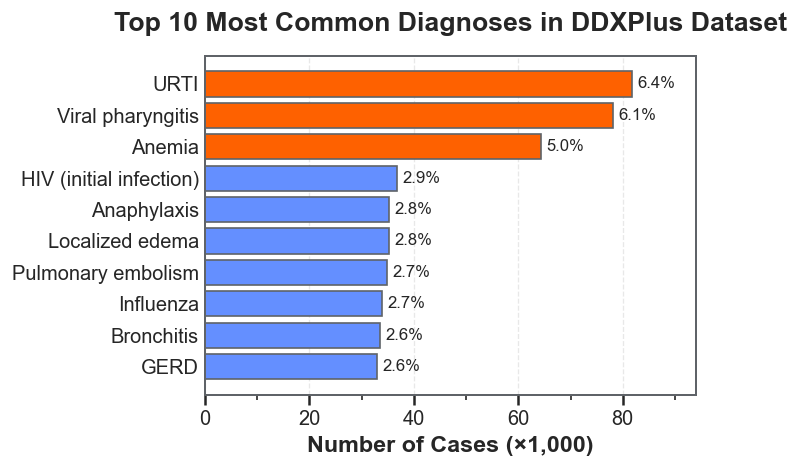

✓ Saved: figures\01b_disease_top20.png


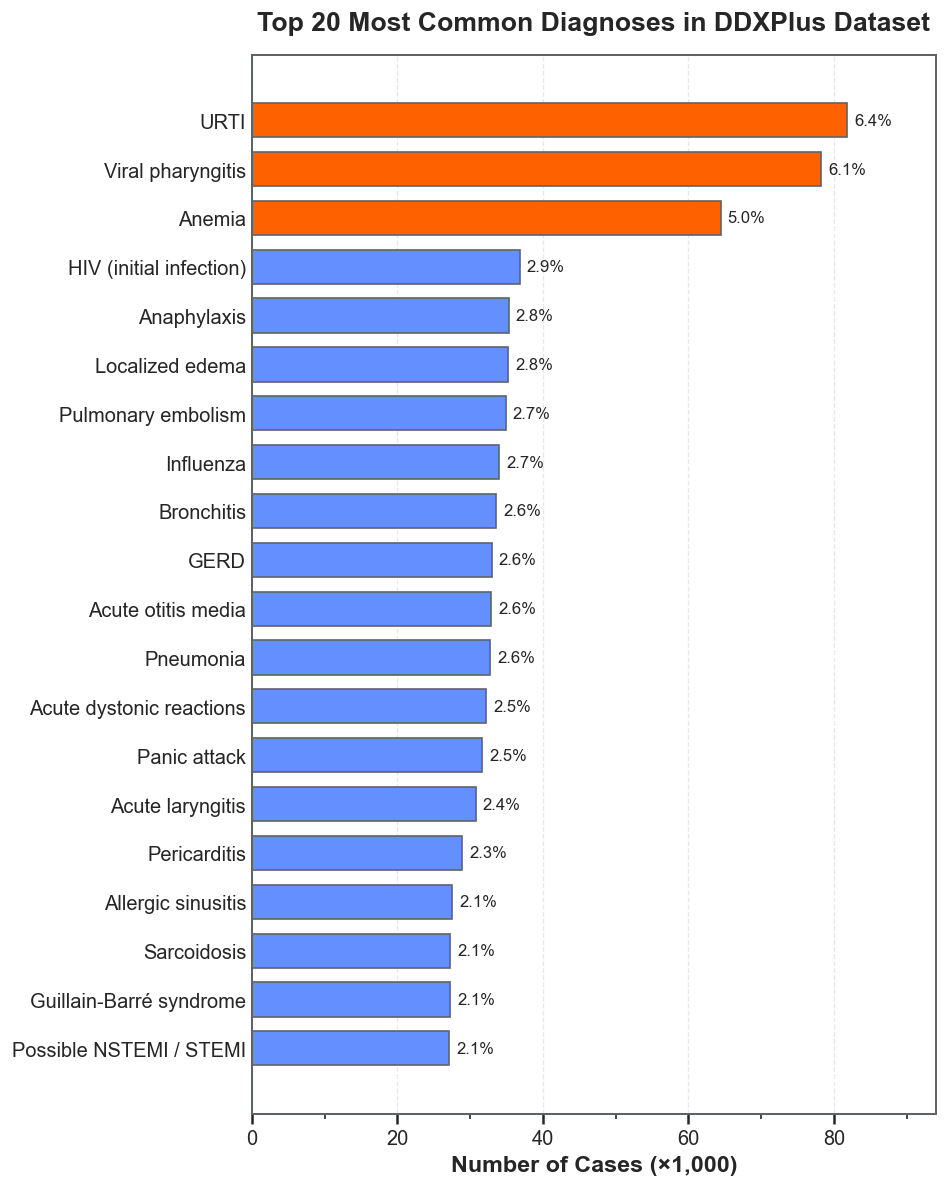


✓ Created two versions:
  • 01a_disease_top10.png - Main presentation figure
  • 01b_disease_top20.png - Detailed/appendix figure


In [45]:
# Figure 1: Top diseases by Frequencies

# Formatter function (define once at top)
def thousands_formatter(x, pos):
    """Format axis values in thousands"""
    return f'{x/1000:.0f}'

# ============================================================================
# Figure 1a: Top 10 Diseases (Main Figure for presentation)
# ============================================================================

fig, ax = plt.subplots()

top_10 = disease_counts.head(10)
total_cases = len(df_all)

# Color scheme: Top 3 highlighted
colors = [IBM_COLORS['orange'] if i < 3 else IBM_COLORS['blue'] 
          for i in range(len(top_10))]

bars = ax.barh(range(len(top_10)), top_10.values, 
               color=colors, 
               edgecolor=IBM_COLORS['gray'])

# Y-axis
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10.index)
ax.invert_yaxis()

# X-axis: Scale to thousands
ax.set_xlabel('Number of Cases (×1,000)', fontweight='bold')
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax.xaxis.set_minor_locator(MultipleLocator(10000))

# Make ticks bigger (only thing NOT in rcParams)
ax.tick_params(axis='x', which='major', length=6, width=1.5)
ax.tick_params(axis='x', which='minor', length=3, width=1.0)

# Title
ax.set_title('Top 10 Most Common Diagnoses in DDXPlus Dataset', 
             fontweight='bold', pad=15)

# Add percentage labels
for i, (idx, val) in enumerate(top_10.items()):
    percentage = (val / total_cases) * 100
    ax.text(val + 1000, i, f'{percentage:.1f}%', 
            va='center', ha='left', 
            fontsize=10)

# Grid (uses rcParams: linewidth=0.8, alpha=0.5, color=#D9D9D9)
ax.grid(axis='x', linestyle='--')  # Only specify axis and linestyle!

# Expand x-axis for labels
ax.set_xlim(0, top_10.values.max() * 1.15)

plt.tight_layout()
save_fig(fig, '01a_disease_top10.png')
plt.show()


# ============================================================================
# Figure 1b: Top 20 Diseases (Detailed/Appendix)
# ============================================================================

fig, ax = plt.subplots(figsize=(8, 10))

top_20 = disease_counts.head(20)

colors = [IBM_COLORS['orange'] if i < 3 else IBM_COLORS['blue'] 
          for i in range(len(top_20))]

bars = ax.barh(range(len(top_20)), top_20.values, 
               color=colors, 
               edgecolor=IBM_COLORS['gray'],
               height=0.7)

ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20.index)
ax.invert_yaxis()

ax.set_xlabel('Number of Cases (×1,000)', fontweight='bold')
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax.xaxis.set_minor_locator(MultipleLocator(10000))

ax.tick_params(axis='x', which='major', length=6, width=1.5)
ax.tick_params(axis='x', which='minor', length=3, width=1.0)

ax.set_title('Top 20 Most Common Diagnoses in DDXPlus Dataset', 
             fontweight='bold', pad=15)

for i, (idx, val) in enumerate(top_20.items()):
    percentage = (val / total_cases) * 100
    ax.text(val + 1000, i, f'{percentage:.1f}%', 
            va='center', ha='left', 
            fontsize=10)

# Grid (uses rcParams settings automatically!)
ax.grid(axis='x', linestyle='--')

ax.set_xlim(0, top_20.values.max() * 1.15)

plt.tight_layout()
save_fig(fig, '01b_disease_top20.png')
plt.show()

print("\n" + "="*70)
print("✓ Created two versions:")
print("  • 01a_disease_top10.png - Main presentation figure")
print("  • 01b_disease_top20.png - Detailed/appendix figure")
print("="*70)


✓ Saved: figures\02_dataset_split.png


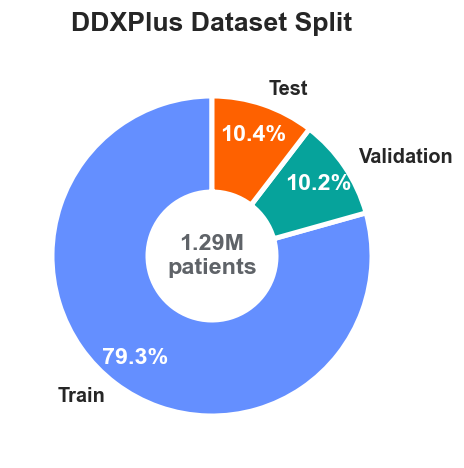


Dataset split (Total: 1,292,579 patients):
  Train: 1,025,602 (79.3%)
  Validation: 132,448 (10.2%)
  Test: 134,529 (10.4%)


In [46]:
# ============================================================================
# Figure 2: Dataset Split (Donut Chart)
# ============================================================================

fig, ax = plt.subplots()

splits = ['Train', 'Validation', 'Test']
sizes = [len(dataset['train']), len(dataset['validate']), len(dataset['test'])]
total = sum(sizes)

colors_split = [IBM_COLORS['blue'], IBM_COLORS['teal'], IBM_COLORS['orange']]

# Donut chart (pie with center hole)
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=splits,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_split,
    wedgeprops={'edgecolor': 'white', 'linewidth': 3, 'width': 0.6},  # width creates donut
    pctdistance=0.8
)

# Style percentages
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)

# Style labels
for text in texts:
    text.set_fontweight('bold')

# Add total in center
ax.text(0, 0, f'{total/1e6:.2f}M\npatients', 
        ha='center', va='center', 
        fontsize=14, fontweight='bold',
        color=IBM_COLORS['gray'])

# Title
ax.set_title('DDXPlus Dataset Split', fontweight='bold', pad=15)

plt.tight_layout()
save_fig(fig, '02_dataset_split.png')
plt.show()

# Print details
print(f"\nDataset split (Total: {total:,} patients):")
for split, size in zip(splits, sizes):
    pct = size / total * 100
    print(f"  {split}: {size:,} ({pct:.1f}%)")


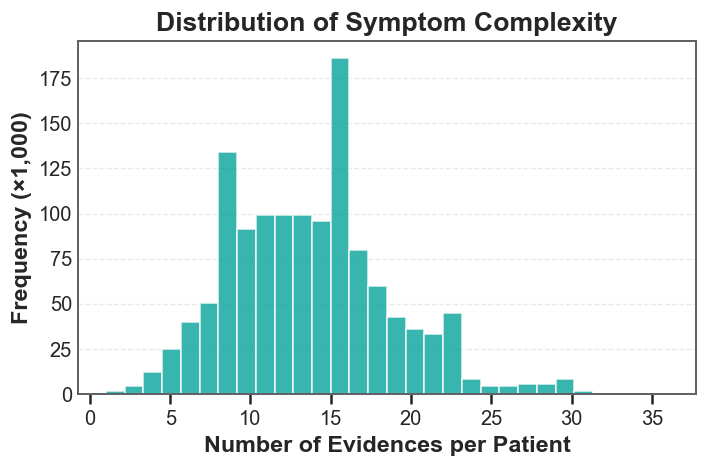


**Symptom Complexity Statistics:**

| Metric | Value |
|--------|-------|
| Mean | 13.6 |
| Median | 13 |
| Std Dev | 5.0 |
| Range | 1 - 36 |
| Total Patients | 1,278,666 |


In [47]:

# Formatter for y-axis (thousands)
def thousands_formatter(x, pos):
    return f'{x/1000:.0f}'

# ============================================================================
# Figure 3: Symptom Complexity Distribution
# ============================================================================

fig, ax = plt.subplots()

# Histogram
ax.hist(df_all['num_evidences_effective'], 
        bins=30, 
        color=IBM_COLORS['teal'], 
        edgecolor='white',
        alpha=0.8)

# Y-axis: scale to thousands
ax.set_ylabel('Frequency (×1,000)', fontweight='bold')
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Labels
ax.set_xlabel('Number of Evidences per Patient', fontweight='bold')
ax.set_title('Distribution of Symptom Complexity', fontweight='bold')
ax.tick_params(axis='x', which='major', length=6, width=1.5)

# Grid
ax.grid(axis='y', linestyle='--')

plt.tight_layout()
# save_fig(fig, '03_symptom_complexity.png')
plt.show()

# Statistics display
mean_val = df_all['num_evidences_effective'].mean()
median_val = df_all['num_evidences_effective'].median()
std_val = df_all['num_evidences_effective'].std()
min_val = df_all['num_evidences_effective'].min()
max_val = df_all['num_evidences_effective'].max()

display(Markdown(f"""
**Symptom Complexity Statistics:**

| Metric | Value |
|--------|-------|
| Mean | {mean_val:.1f} |
| Median | {median_val:.0f} |
| Std Dev | {std_val:.1f} |
| Range | {min_val} - {max_val} |
| Total Patients | {len(df_all):,} |
"""))


C:\Users\julia\AppData\Local\Temp\ipykernel_29144\4265694697.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(age_symptom_data,
C:\Users\julia\AppData\Local\Temp\ipykernel_29144\4265694697.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(sex_symptom_data,


✓ Saved: figures\04_symptom_complexity_demographics.png


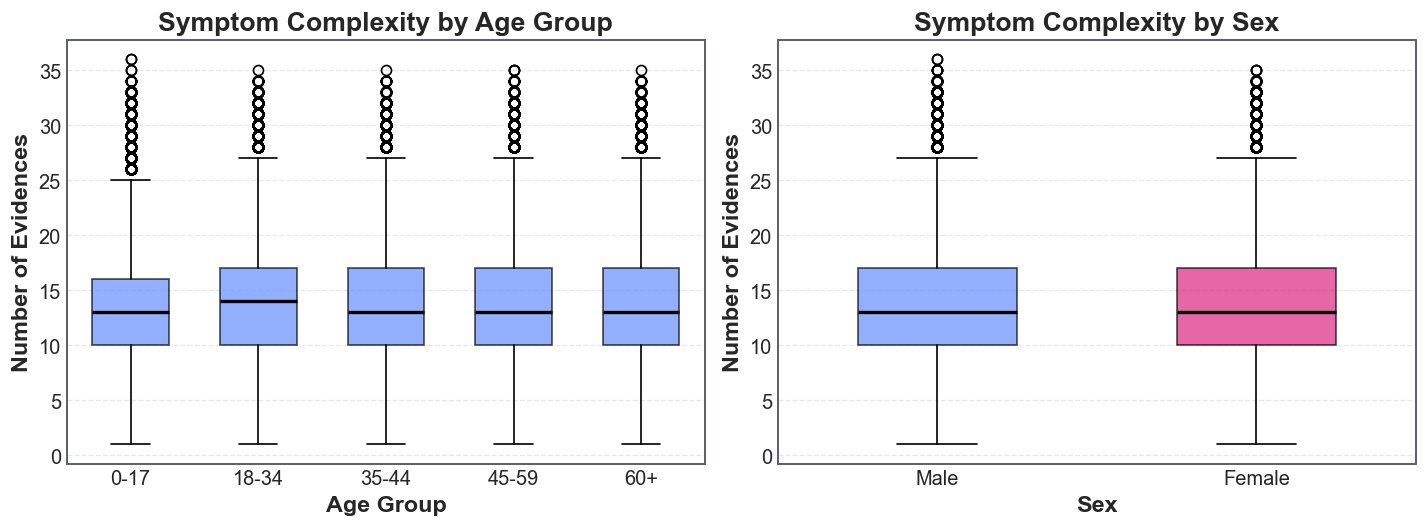

### Symptom Complexity by Age Group

,Age Group,Count,Mean,Median,Std
0,0-17,"229,364",13.4,13,5.2
1,18-34,"334,386",13.8,14,5.0
2,35-44,"175,620",13.7,13,4.9
3,45-59,"268,726",13.7,13,5.0
4,60+,"249,805",13.5,13,5.0


### Symptom Complexity by Sex

,Sex,Count,Mean,Median,Std
0,Male,"620,614",13.6,13,5.0
1,Female,"658,052",13.7,13,5.0


In [48]:
# ============================================================================
# Figure 4: Symptom Complexity by Demographics
# ============================================================================

# Define age groups: biology-informed bins (aligned with aging waves at 44 and 60)
age_bins = [0, 18, 35, 45, 60, 110]
age_labels = ['0-17', '18-34', '35-44', '45-59', '60+']

# Create age groups
df_all['age_group'] = pd.cut(df_all['AGE'], 
                               bins=age_bins,
                               labels=age_labels)

# Two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# ============================================================================
# LEFT: Symptoms by Age Group
# ============================================================================

# Use the SAME labels list
age_symptom_data = [df_all[df_all['age_group'] == group]['num_evidences_effective'].values 
                    for group in age_labels]

bp1 = ax1.boxplot(age_symptom_data, 
                   labels=age_labels,  
                   patch_artist=True, 
                   widths=0.6)

# Style boxes
for patch in bp1['boxes']:
    patch.set_facecolor(IBM_COLORS['blue'])
    patch.set_alpha(0.7)

# Style medians
for median in bp1['medians']:
    median.set_color('black')
    median.set_linewidth(2)

# Labels
ax1.set_xlabel('Age Group', fontweight='bold')
ax1.set_ylabel('Number of Evidences', fontweight='bold')
ax1.set_title('Symptom Complexity by Age Group', fontweight='bold')

# Grid
ax1.grid(axis='y', linestyle='--')

# ============================================================================
# RIGHT: Symptoms by Sex
# ============================================================================

sex_labels = ['Male', 'Female']
sex_symptom_data = [df_all[df_all['SEX'] == sex]['num_evidences_effective'].values 
                    for sex in ['M', 'F']]

bp2 = ax2.boxplot(sex_symptom_data, 
                   labels=sex_labels,
                   patch_artist=True, 
                   widths=0.5)

# Color boxes
bp2['boxes'][0].set_facecolor(IBM_COLORS['blue'])
bp2['boxes'][1].set_facecolor(IBM_COLORS['magenta'])

for patch in bp2['boxes']:
    patch.set_alpha(0.7)

# Style medians
for median in bp2['medians']:
    median.set_color('black')
    median.set_linewidth(2)

# Labels
ax2.set_xlabel('Sex', fontweight='bold')
ax2.set_ylabel('Number of Evidences', fontweight='bold')
ax2.set_title('Symptom Complexity by Sex', fontweight='bold')

# Grid
ax2.grid(axis='y', linestyle='--')

plt.tight_layout()
save_fig(fig, '04_symptom_complexity_demographics.png')
plt.show()

# ============================================================================
# Statistics
# ============================================================================

display(Markdown("### Symptom Complexity by Age Group"))

age_stats = []
for group in age_labels:  # Use the SAME list
    data = df_all[df_all['age_group'] == group]['num_evidences_effective']
    age_stats.append({
        'Age Group': group,
        'Count': f"{len(data):,}",
        'Mean': f"{data.mean():.1f}",
        'Median': f"{data.median():.0f}",
        'Std': f"{data.std():.1f}"
    })

display(pd.DataFrame(age_stats))

display(Markdown("### Symptom Complexity by Sex"))

sex_stats = []
for sex, label in zip(['M', 'F'], ['Male', 'Female']):
    data = df_all[df_all['SEX'] == sex]['num_evidences_effective']
    sex_stats.append({
        'Sex': label,
        'Count': f"{len(data):,}",
        'Mean': f"{data.mean():.1f}",
        'Median': f"{data.median():.0f}",
        'Std': f"{data.std():.1f}"
    })

display(pd.DataFrame(sex_stats))

# Clean up
df_all.drop('age_group', axis=1, inplace=True)


#### Symptom Complexity by Demographics

DDXPlus shows uniform symptom complexity across age groups (median: 13-14) and sex (Male: 13, Female: 13). This contrasts with clinical epidemiology where multimorbidity increases substantially with age (81.5% of adults 85+ have multiple chronic conditions)¹ and women with multimorbidity report significantly higher symptom burden than men (4.9 points higher disease burden, p=0.003)².

This uniform distribution suggests DDXPlus models **single-disease diagnostic scenarios** rather than realistic multimorbid presentations. While age and sex remain important for predicting *specific diagnoses*, they do not predict symptom count in this synthetic dataset.

**Implication for modeling:** Demographics alone are NOT predictive of symptom complexity. This validates that the diagnostic assistant must rely primarily on symptom patterns rather than patient demographics.

---
**References:**
1. Eckerblad J, et al. Symptom burden in community-dwelling older people with multimorbidity. *BMC Geriatr*. 2015;15:1.
2. Lim A, et al. Gender differences in disease burden, symptom burden, and quality of life among people with heart failure and multimorbidity. *J Adv Nurs*. 2025. doi:10.1111/jan.16797


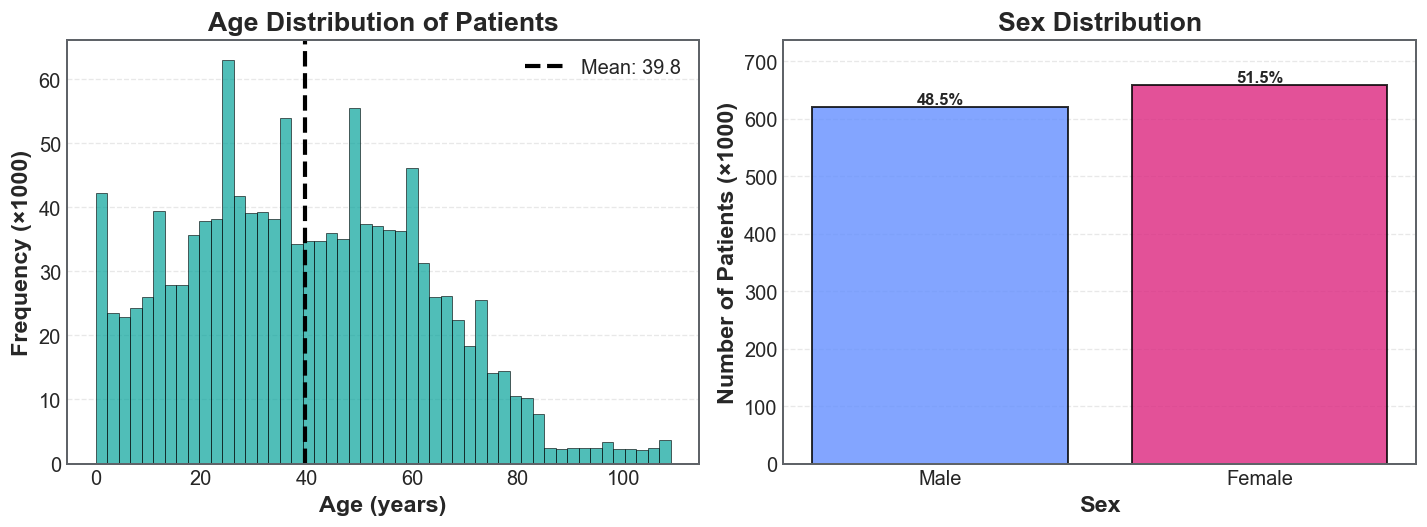

### Demographics Summary

,Metric,Value
0,Total Patients,"1,278,666"
1,Age Range,0-109 years
2,Mean Age,39.8 years
3,Median Age,39.0 years
4,Male,"620,614"
5,Female,"658,052"
6,Male %,48.5%
7,Female %,51.5%


In [49]:
# ============================================================================
# Figure 5: Demographics Analysis
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# ============================================================================
# LEFT: Age Distribution
# ============================================================================

ax1.hist(df_all['AGE'], bins=50, color=IBM_COLORS['teal'], 
         edgecolor='black', alpha=0.7, linewidth=0.5)

mean_age = df_all['AGE'].mean()
ax1.axvline(mean_age, color='black', linestyle='--', linewidth=2.5, 
           label=f'Mean: {mean_age:.1f}')

ax1.set_xlabel('Age (years)', fontweight='bold')
ax1.set_ylabel('Frequency (×1000)', fontweight='bold')
ax1.set_title('Age Distribution of Patients', fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(axis='y', linestyle='--')
ax1.set_axisbelow(True)

# Scale y-axis to thousands
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}'))

# ============================================================================
# RIGHT: Sex Distribution
# ============================================================================

sex_counts = df_all['SEX'].value_counts()
sex_labels = ['Male', 'Female']
sex_values = [sex_counts['M'], sex_counts['F']]
colors_sex = [IBM_COLORS['blue'], IBM_COLORS['magenta']]

bars = ax2.bar(sex_labels, sex_values, color=colors_sex, 
              edgecolor='black', linewidth=1.2, alpha=0.8)

ax2.set_xlabel('Sex', fontweight='bold')
ax2.set_ylabel('Number of Patients (×1000)', fontweight='bold')
ax2.set_title('Sex Distribution', fontweight='bold')
ax2.grid(axis='y', linestyle='--')
ax2.set_axisbelow(True)
ax2.set_ylim(0, max(sex_values) * 1.12)

# Scale y-axis to thousands
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}'))

# Value labels on bars (percentage only)
for bar, value in zip(bars, sex_values):
    height = bar.get_height()
    percentage = (value / len(df_all)) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{percentage:.1f}%',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
# save_fig(fig, '05_demographics.png')
plt.show()

# ============================================================================
# Summary Statistics
# ============================================================================

display(Markdown("### Demographics Summary"))

demo_stats = pd.DataFrame({
    'Metric': ['Total Patients', 'Age Range', 'Mean Age', 'Median Age', 
               'Male', 'Female', 'Male %', 'Female %'],
    'Value': [
        f"{len(df_all):,}",
        f"{df_all['AGE'].min()}-{df_all['AGE'].max()} years",
        f"{df_all['AGE'].mean():.1f} years",
        f"{df_all['AGE'].median():.1f} years",
        f"{sex_counts['M']:,}",
        f"{sex_counts['F']:,}",
        f"{(sex_counts['M']/len(df_all)*100):.1f}%",
        f"{(sex_counts['F']/len(df_all)*100):.1f}%"
    ]
})

display(demo_stats)


C:\Users\julia\AppData\Local\Temp\ipykernel_29144\3917496346.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(symptom_by_disease, labels=top_diseases, patch_artist=True,


✓ Saved: figures\06_symptom_complexity_by_disease.png


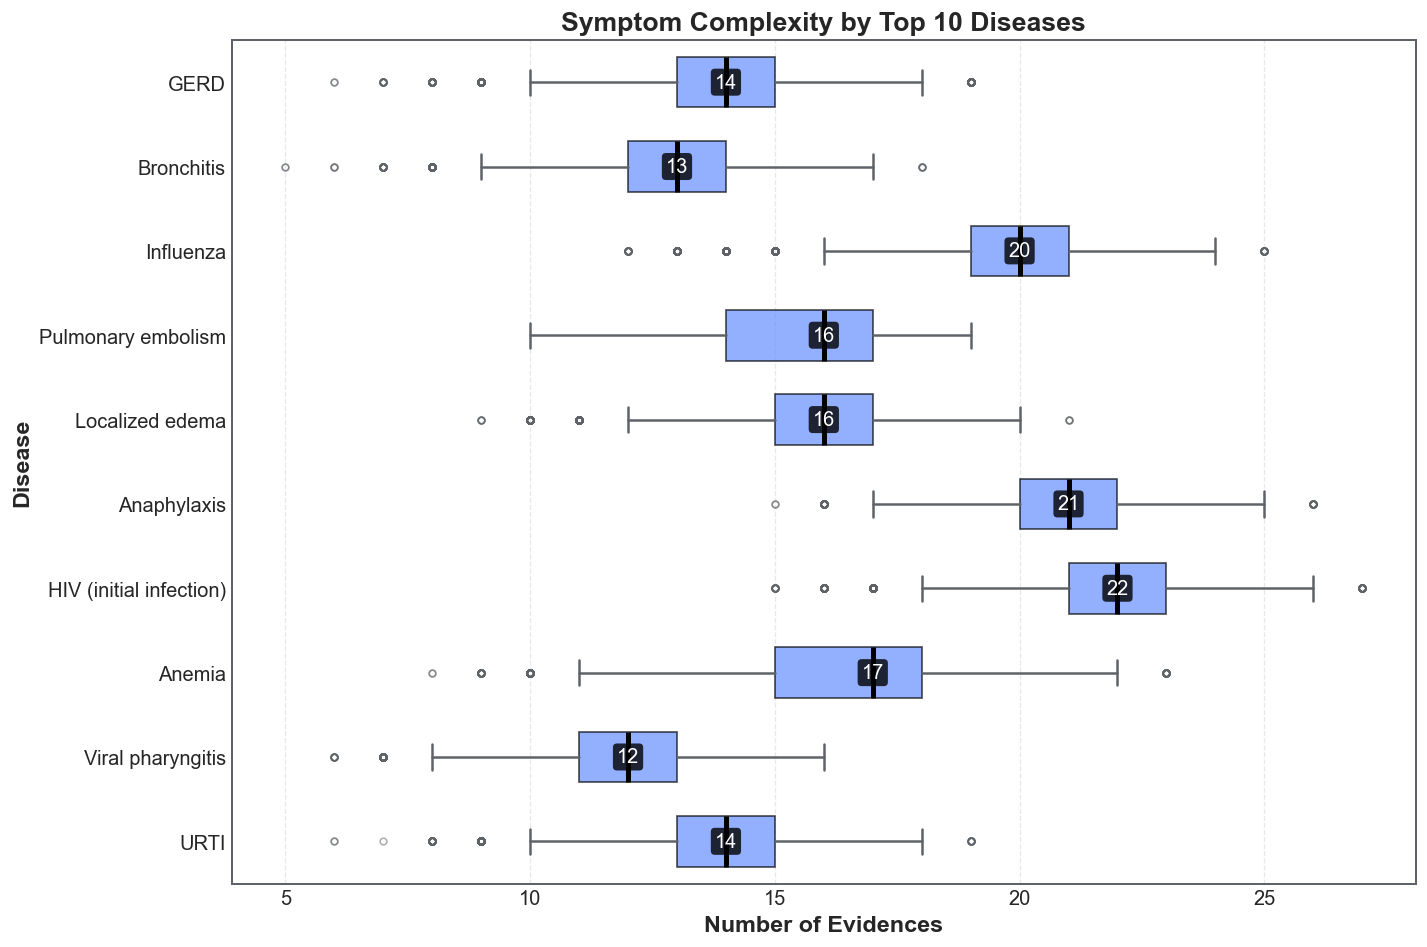


Symptom Complexity by Disease:
  URTI                          : Median 14 evidences
  Viral pharyngitis             : Median 12 evidences
  Anemia                        : Median 17 evidences
  HIV (initial infection)       : Median 22 evidences
  Anaphylaxis                   : Median 21 evidences
  Localized edema               : Median 16 evidences
  Pulmonary embolism            : Median 16 evidences
  Influenza                     : Median 20 evidences
  Bronchitis                    : Median 13 evidences
  GERD                          : Median 14 evidences


In [52]:
# ============================================================================
# Figure 6: Symptom Complexity by Top 10 Diseases
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Get top 10 diseases
top_diseases = df_all['PATHOLOGY'].value_counts().head(10).index

# Create data for box plots
symptom_by_disease = [df_all[df_all['PATHOLOGY'] == disease]['num_evidences_effective'].values 
                      for disease in top_diseases]

bp = ax.boxplot(symptom_by_disease, labels=top_diseases, patch_artist=True,
                vert=False, widths=0.6)

# Color boxes
for patch in bp['boxes']:
    patch.set_facecolor(IBM_COLORS['blue'])
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Style medians - BLACK and THICK
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(3)

# Style whiskers and caps
for whisker in bp['whiskers']:
    whisker.set_color(IBM_COLORS['gray'])
    whisker.set_linewidth(1.5)
for cap in bp['caps']:
    cap.set_color(IBM_COLORS['gray'])
    cap.set_linewidth(1.5)

# Style outliers
for flier in bp['fliers']:
    flier.set_marker('o')
    flier.set_markerfacecolor('none')
    flier.set_markeredgecolor(IBM_COLORS['gray'])
    flier.set_markersize(4)
    flier.set_alpha(0.5)

ax.set_xlabel('Number of Evidences', fontweight='bold')
ax.set_ylabel('Disease', fontweight='bold')
ax.set_title('Symptom Complexity by Top 10 Diseases', fontweight='bold')
ax.grid(axis='x', linestyle='--')
ax.set_axisbelow(True)

# Add median values INSIDE boxes (white text, bold)
for i, disease in enumerate(top_diseases):
    median_val = df_all[df_all['PATHOLOGY'] == disease]['num_evidences_effective'].median()
    ax.text(median_val, i+1, f'{median_val:.0f}', 
           va='center', ha='center', fontsize=12,
           color='white',
           bbox=dict(boxstyle='round,pad=0.2', facecolor='black', 
                    edgecolor='none', alpha=0.8))

plt.tight_layout()
save_fig(fig, '06_symptom_complexity_by_disease.png')
plt.show()

# Print insights
print("\nSymptom Complexity by Disease:")
for disease in top_diseases:
    median_symp = df_all[df_all['PATHOLOGY'] == disease]['num_evidences_effective'].median()
    print(f"  {disease:30s}: Median {median_symp:.0f} evidences")


## 5. Evidence & Condition Analysis

**Purpose:** Understand symptom/finding structure and condition mappings for feature engineering.


In [53]:
# 5.1 Evidence Mapping Overview
print("="*70)
print("EVIDENCE MAPPING STRUCTURE")
print("="*70)

print(f"Total evidence codes in mapping: {len(evidences)}")

# Show example structure
sample_code = 'E_48'
if sample_code in evidences:
    print(f"\nExample evidence: {sample_code}")
    print(json.dumps(evidences[sample_code], indent=2))


EVIDENCE MAPPING STRUCTURE
Total evidence codes in mapping: 223

Example evidence: E_48
{
  "name": "E_48",
  "code_question": "E_48",
  "question_fr": "Habitez-vous avec 4 personnes ou plus?",
  "question_en": "Do you live with 4 or more people?",
  "is_antecedent": true,
  "default_value": 0,
  "value_meaning": {},
  "possible-values": [],
  "data_type": "B"
}


In [54]:
# 5.2 Evidence Type Breakdown
print("\n" + "="*70)
print("EVIDENCE TYPE ANALYSIS")
print("="*70)

# Count by data type
evidence_types = {}
for code, info in evidences.items():
    dtype = info.get('data_type', 'unknown')
    evidence_types[dtype] = evidence_types.get(dtype, 0) + 1

print("Evidence types:")
for etype, count in sorted(evidence_types.items(), key=lambda x: x[1], reverse=True):
    percentage = count / len(evidences) * 100
    print(f"  {etype:20s}: {count:3d} codes ({percentage:5.1f}%)")

# Binary, Categorical, Multi-choice breakdown
print("\nType meanings:")
print("  B (Binary):      Yes/No questions")
print("  C (Categorical): Single choice from multiple options")  
print("  M (Multi-choice): Multiple selections possible")

# Count evidences with value mappings (categorical)
categorical_evidences = [k for k, v in evidences.items() if v.get('possible-values')]
print(f"\nCategorical evidences with value mappings: {len(categorical_evidences)}")



EVIDENCE TYPE ANALYSIS
Evidence types:
  B                   : 208 codes ( 93.3%)
  C                   :  10 codes (  4.5%)
  M                   :   5 codes (  2.2%)

Type meanings:
  B (Binary):      Yes/No questions
  C (Categorical): Single choice from multiple options
  M (Multi-choice): Multiple selections possible

Categorical evidences with value mappings: 15


VISUALIZING EVIDENCE TYPE DISTRIBUTION
✓ Saved: figures\07_evidence_type_distribution_pie.png


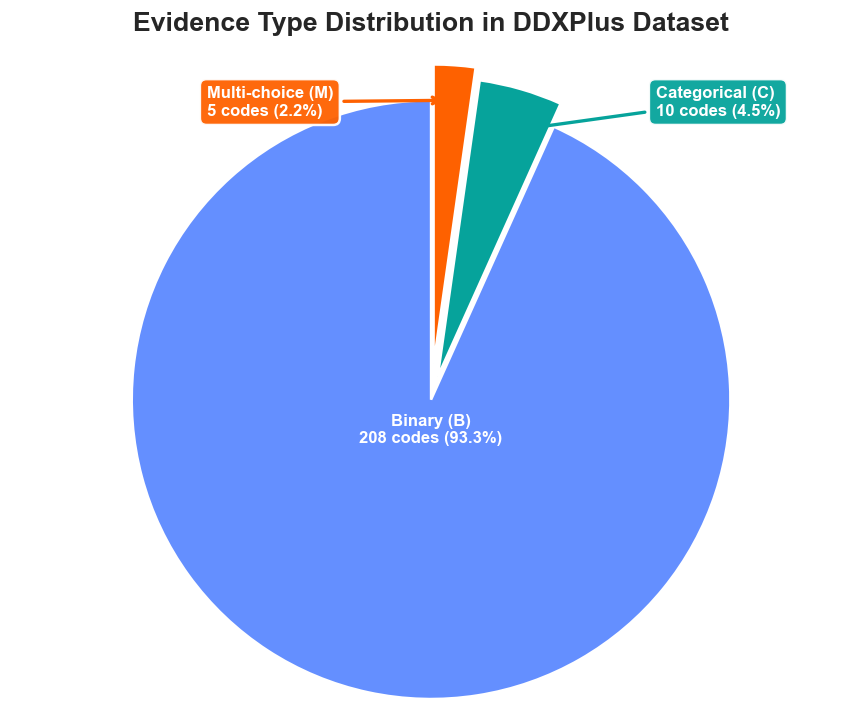

### Evidence Type Summary

,Type,Count,Percentage
0,Binary (B),208,93.3%
1,Categorical (C),10,4.5%
2,Multi-choice (M),5,2.2%


In [55]:
# Section 5.2 - Evidence Type Distribution Visualization
# ============================================================================
# Figure 7: Evidence Type Distribution
# ============================================================================

print("="*70)
print("VISUALIZING EVIDENCE TYPE DISTRIBUTION")
print("="*70)

# Prepare data
type_counts = pd.Series([v.get("data_type","UNK") for v in evidences.values()]).value_counts()

counts = np.array([type_counts.get("B",0), type_counts.get("C",0), type_counts.get("M",0)])
labels = ["Binary (B)", "Categorical (C)", "Multi-choice (M)"]
percentages = (counts/counts.sum())*100

# Create figure - OVERRIDE to slightly larger size for pie charts
fig, ax = plt.subplots(figsize=(8, 6))  # Bigger than default (6, 4)

# Use IBM colorblind-safe colors
colors = [IBM_COLORS['blue'], IBM_COLORS['teal'], IBM_COLORS['orange']]

# Create pie chart
explode = (0, 0.08, 0.12)

wedges, texts, autotexts = ax.pie(
    counts,
    labels=None,
    autopct='',
    startangle=90,
    colors=colors,
    explode=explode,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

# Binary (B) - INSIDE the pie chart
ax.text(0, -0.1, f'{labels[0]}\n{counts[0]} codes ({percentages[0]:.1f}%)', 
        ha='center', va='center', 
        weight='bold', color='white')  # Uses rcParams font size

# Categorical (C)
ax.annotate(f'{labels[1]}\n{counts[1]} codes ({percentages[1]:.1f}%)', 
            xy=(0.28, 0.90),
            xytext=(0.75, 0.95),
            weight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor=colors[1], 
                     edgecolor='white', linewidth=1.5, alpha=0.95),
            color='white',
            arrowprops=dict(arrowstyle='->', lw=2, color=colors[1]))

# Multi-choice (M)
ax.annotate(f'{labels[2]}\n{counts[2]} codes ({percentages[2]:.1f}%)', 
            xy=(0.05, 1.00),
            xytext=(-0.75, 0.95),
            weight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor=colors[2], 
                     edgecolor='white', linewidth=1.5, alpha=0.95),
            color='white',
            arrowprops=dict(arrowstyle='->', lw=2, color=colors[2]))

ax.set_title('Evidence Type Distribution in DDXPlus Dataset', fontweight='bold')

# More generous limits for bigger figure
ax.set_aspect('equal')
plt.xlim(-1.4, 1.4)
plt.ylim(-0.9, 1.2)

plt.tight_layout()
save_fig(fig, '07_evidence_type_distribution_pie.png')
plt.show()

display(Markdown("### Evidence Type Summary"))

type_summary = pd.DataFrame({
    'Type': labels,
    'Count': counts,
    'Percentage': [f'{p:.1f}%' for p in percentages]
})

display(type_summary)


✓ Saved: figures\07_evidence_type_distribution_bar.png


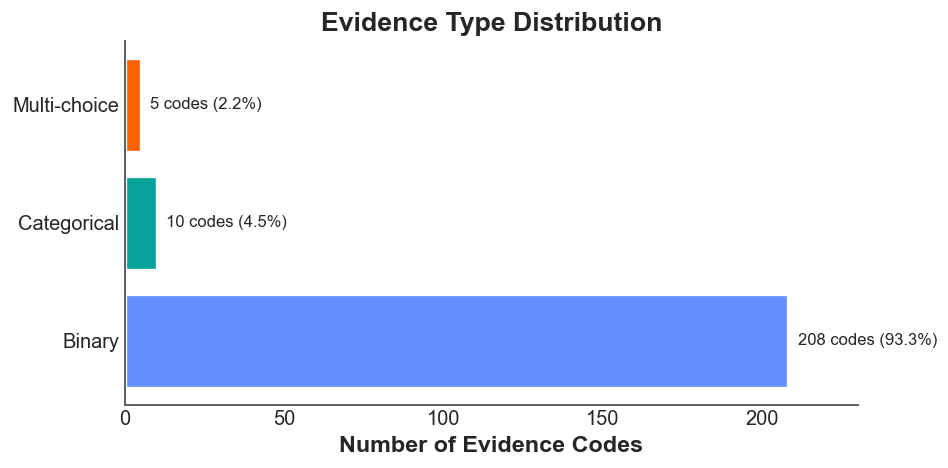

In [56]:
# ============================================================================
# Figure 7 (Alternative): Evidence Type Distribution - Horizontal Bars
# ============================================================================

fig, ax = plt.subplots(figsize=(8, 4))

# Prepare data
type_counts = pd.Series([v.get("data_type","UNK") for v in evidences.values()]).value_counts()
counts = np.array([type_counts.get("B",0), type_counts.get("C",0), type_counts.get("M",0)])
labels = ["Binary", "Categorical", "Multi-choice"]
percentages = (counts/counts.sum())*100
colors_bar = [IBM_COLORS['blue'], IBM_COLORS['teal'], IBM_COLORS['orange']]

# Create horizontal bars
bars = ax.barh(labels, counts, color=colors_bar, edgecolor='white', linewidth=2)

# Add count and percentage labels on bars
for bar, count, pct in zip(bars, counts, percentages):
    ax.text(bar.get_width() + 3, bar.get_y() + bar.get_height()/2, 
            f'{count} codes ({pct:.1f}%)', 
            va='center')

ax.set_xlabel('Number of Evidence Codes', weight='bold')
ax.set_title('Evidence Type Distribution', weight='bold')
ax.set_xlim(0, 230)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
save_fig(fig, '07_evidence_type_distribution_bar.png')
plt.show()


In [57]:
# Display examples of each evidence type
print("\n" + "="*70)
print("EVIDENCE EXAMPLES")
print("="*70)

# Count by data type
binary_evidences = []
categorical_evidences = []
multichoice_evidences = []

for code, info in evidences.items():
    dtype = info['data_type']
    if dtype == 'B':
        binary_evidences.append(code)
    elif dtype == 'C':
        categorical_evidences.append(code)
    elif dtype == 'M':
        multichoice_evidences.append(code)

# ============================================================================
# 1. BINARY EVIDENCES
# ============================================================================
print("\n1. BINARY EVIDENCES (Yes/No questions)")
print("-" * 70)

for i, code in enumerate(binary_evidences[:3], 1):
    ev = evidences[code]
    print(f"\nExample {i}: {code}")
    print(f"  Question: {ev['question_en']}")
    print(f"  Is antecedent: {ev['is_antecedent']}")
    print(f"  Default value: {ev['default_value']}")

# ============================================================================
# 2. CATEGORICAL EVIDENCES
# ============================================================================
print("\n2. CATEGORICAL EVIDENCES (Single choice)")
print("-" * 70)

if categorical_evidences:
    for i, code in enumerate(categorical_evidences[:3], 1):
        ev = evidences[code]
        print(f"\nExample {i}: {code}")
        print(f"  Question: {ev['question_en']}")
        print(f"  Is antecedent: {ev['is_antecedent']}")
        
        # Show possible values if they exist
        if 'possible-values' in ev:
            print(f"  Possible values: {ev['possible-values'][:5]}")  # First 5
        
        # Show value meanings if they exist
        if 'value_meaning' in ev and ev['value_meaning']:
            print(f"  Value meanings (sample):")
            for j, (val_code, meaning) in enumerate(list(ev['value_meaning'].items())[:3], 1):
                print(f"    {val_code}: {meaning}")
            if len(ev['value_meaning']) > 3:
                print(f"    ... and {len(ev['value_meaning']) - 3} more values")
else:
    print("  No categorical evidences found in dataset")

# ============================================================================
# 3. MULTI-CHOICE EVIDENCES
# ============================================================================
print("\n3. MULTI-CHOICE EVIDENCES (Multiple selections)")
print("-" * 70)

if multichoice_evidences:
    for i, code in enumerate(multichoice_evidences[:3], 1):
        ev = evidences[code]
        print(f"\nExample {i}: {code}")
        print(f"  Question: {ev['question_en']}")
        print(f"  Is antecedent: {ev['is_antecedent']}")
        
        # Show possible values if they exist
        if 'possible-values' in ev:
            print(f"  Possible values: {ev['possible-values'][:5]}")  # First 5
        
        # Show value meanings if they exist
        if 'value_meaning' in ev and ev['value_meaning']:
            print(f"  Value meanings (sample):")
            for j, (val_code, meaning) in enumerate(list(ev['value_meaning'].items())[:3], 1):
                print(f"    {val_code}: {meaning}")
            if len(ev['value_meaning']) > 3:
                print(f"    ... and {len(ev['value_meaning']) - 3} more values")
else:
    print("  No multi-choice evidences found in dataset")

# Summary
print("\n" + "="*70)
print("EVIDENCE TYPE SUMMARY")
print("="*70)
print(f"Binary evidences: {len(binary_evidences)}")
print(f"Categorical evidences: {len(categorical_evidences)}")
print(f"Multi-choice evidences: {len(multichoice_evidences)}")
print(f"Total: {len(binary_evidences) + len(categorical_evidences) + len(multichoice_evidences)}")



EVIDENCE EXAMPLES

1. BINARY EVIDENCES (Yes/No questions)
----------------------------------------------------------------------

Example 1: E_91
  Question: Do you have a fever (either felt or measured with a thermometer)?
  Is antecedent: False
  Default value: 0

Example 2: E_53
  Question: Do you have pain somewhere, related to your reason for consulting?
  Is antecedent: False
  Default value: 0

Example 3: E_159
  Question: Did you lose consciousness?
  Is antecedent: False
  Default value: 0

2. CATEGORICAL EVIDENCES (Single choice)
----------------------------------------------------------------------

Example 1: E_59
  Question: How fast did the pain appear?
  Is antecedent: False
  Possible values: [0, 1, 2, 3, 4]

Example 2: E_56
  Question: How intense is the pain?
  Is antecedent: False
  Possible values: [0, 1, 2, 3, 4]

Example 3: E_58
  Question: How precisely is the pain located?
  Is antecedent: False
  Possible values: [0, 1, 2, 3, 4]

3. MULTI-CHOICE EVIDENCES (Mul

In [59]:
# Section 5.3 Check: Is INITIAL_EVIDENCE always in the EVIDENCES list?
print("Verifying INITIAL_EVIDENCE definition...")

def to_base(code: str) -> str:
    return code.split("_@_")[0]  # safe for both base and value-coded

# Test: Is initial evidence always part of all evidences?
def check_initial_in_evidences(row):
    initial = row["INITIAL_EVIDENCE"]
    base_set = {to_base(c) for c in row["EVIDENCES_list"]}
    return initial in base_set

in_list = df_all.apply(check_initial_in_evidences, axis=1)


print(f"\nIs INITIAL_EVIDENCE always in EVIDENCES list?")
print(f"  Yes: {in_list.sum():,} patients ({in_list.sum()/len(df_all)*100:.1f}%)")
print(f"  No:  {(~in_list).sum():,} patients ({(~in_list).sum()/len(df_all)*100:.1f}%)")

if in_list.all():
    print("\n✓ CONFIRMED: INITIAL_EVIDENCE is always included in EVIDENCES")
    print("  → It's the 'chief complaint' - what patient presented with")
else:
    print("\n⚠ WARNING: INITIAL_EVIDENCE sometimes NOT in EVIDENCES list")
    print("  → May have different meaning than 'first symptom'")

# Check a few examples
print("\n\nExample patients:")
for i in range(3):
    patient = df_all.iloc[i]
    print(f"\nPatient {i}:")
    print(f"  Initial: {patient['INITIAL_EVIDENCE']}")
    print(f"  All evidences: {patient['EVIDENCES_list'][:]}...")
    print(f"  Is initial in list? {patient['INITIAL_EVIDENCE'] in patient['EVIDENCES']}")


Verifying INITIAL_EVIDENCE definition...

Is INITIAL_EVIDENCE always in EVIDENCES list?
  Yes: 1,278,666 patients (100.0%)
  No:  0 patients (0.0%)

✓ CONFIRMED: INITIAL_EVIDENCE is always included in EVIDENCES
  → It's the 'chief complaint' - what patient presented with


Example patients:

Patient 0:
  Initial: E_91
  All evidences: ['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183', 'E_55_@_V_89', 'E_55_@_V_108', 'E_55_@_V_167', 'E_56_@_4', 'E_57_@_V_123', 'E_58_@_3', 'E_59_@_3', 'E_77', 'E_79', 'E_91', 'E_97', 'E_201', 'E_204_@_V_10', 'E_222']...
  Is initial in list? True

Patient 1:
  Initial: E_50
  All evidences: ['E_9', 'E_27', 'E_50', 'E_51', 'E_53', 'E_54_@_V_198', 'E_55_@_V_62', 'E_55_@_V_166', 'E_55_@_V_167', 'E_56_@_7', 'E_57_@_V_123', 'E_58_@_7', 'E_59_@_2', 'E_91', 'E_115', 'E_129', 'E_130_@_V_138', 'E_131_@_V_10', 'E_132_@_0', 'E_133_@_V_90', 'E_133_@_V_91', 'E_133_@_V_95', 'E_133_@_V_110', 'E_133_@_V_111', 'E_134_@_6', 'E_135_@_V_12', 'E_136_@_0', 'E_148', 'E_162

In [60]:
# 5.4 Condition Mapping Overview
print("\n" + "="*70)
print("CONDITION MAPPING STRUCTURE")
print("="*70)

print(f"Total conditions in mapping: {len(conditions)}")
print(f"Unique pathologies in data: {df_all['PATHOLOGY'].nunique()}")

# Example condition structure
sample_condition = 'URTI'
if sample_condition in conditions:
    print(f"\nExample condition: {sample_condition}")
    cond_info = conditions[sample_condition]
    print(f"  Name: {cond_info.get('condition_name', 'N/A')}")
    print(f"  Symptoms: {len(cond_info.get('symptoms', {}))} associated")
    print(f"  Antecedents: {len(cond_info.get('antecedents', {}))} risk factors")



CONDITION MAPPING STRUCTURE
Total conditions in mapping: 49
Unique pathologies in data: 49

Example condition: URTI
  Name: URTI
  Symptoms: 14 associated
  Antecedents: 6 risk factors


In [62]:
# Section 5.5 Analyze antecedents (risk factors vs symptoms)
print("\n" + "="*70)
print("ANTECEDENT ANALYSIS")
print("="*70)

antecedent_codes = [code for code, info in evidences.items() if info['is_antecedent']]
symptom_codes = [code for code, info in evidences.items() if not info['is_antecedent']]


print(f"\nAntecedents (risk factors):  {len(antecedent_codes):>3}")
print(f"Symptoms (current findings): {len(symptom_codes):>3}")

print("\nExample Antecedents (Risk Factors):")
for code in antecedent_codes[:3]:
    print(f"  - {code}: {evidences[code]['question_en']}")

print("\nExample Symptoms (Current Findings):")
for code in symptom_codes[:3]:
    print(f"  - {code}: {evidences[code]['question_en']}")


ANTECEDENT ANALYSIS

Antecedents (risk factors):  113
Symptoms (current findings): 110

Example Antecedents (Risk Factors):
  - E_16: Do you feel anxious?
  - E_102: Are you consulting because you have high blood pressure?
  - E_196: Have you had surgery within the last month?

Example Symptoms (Current Findings):
  - E_91: Do you have a fever (either felt or measured with a thermometer)?
  - E_55: Do you feel pain somewhere?
  - E_53: Do you have pain somewhere, related to your reason for consulting?


In [64]:
# Section 5.6 Evidence Usage Analysis

print("\n" + "="*70)
print("5.6 - EVIDENCE USAGE ANALYSIS")
print("="*70)

# --- Collect evidence codes from dataset ---
all_evidence_codes = []
effective_evidence_codes = []

for evidence_list in df_all['EVIDENCES_list']:
    for evidence in evidence_list:
        base_code = to_base(evidence)
        all_evidence_codes.append(base_code)
        
        if is_effective_item(evidence, evidences):
            effective_evidence_codes.append(base_code)

# --- Compute statistics ---
unique_all = set(all_evidence_codes)
unique_effective = set(effective_evidence_codes)
only_defaults = unique_all - unique_effective

frequency_all = Counter(all_evidence_codes)
frequency_effective = Counter(effective_evidence_codes)

# --- Summary Statistics Table ---
print("\n📊 Summary Statistics:\n")

summary_data = {
    'Metric': [
        'Evidence types in mapping',
        'Used in dataset (any value)',
        'Used with positive findings',
        'Only appear as defaults',
        'Coverage (all)',
        'Coverage (effective)',
        '',
        'Total evidence appearances',
        'Positive findings',
        'Default value occurrences',
        'Default percentage'
    ],
    'Value': [
        f"{len(evidences)}",
        f"{len(unique_all)}",
        f"{len(unique_effective)}",
        f"{len(only_defaults)}",
        f"{len(unique_all)/len(evidences)*100:.1f}%",
        f"{len(unique_effective)/len(evidences)*100:.1f}%",
        '',
        f"{len(all_evidence_codes):,}",
        f"{len(effective_evidence_codes):,}",
        f"{len(all_evidence_codes) - len(effective_evidence_codes):,}",
        f"{(len(all_evidence_codes) - len(effective_evidence_codes))/len(all_evidence_codes)*100:.1f}%"
    ]
}

display(pd.DataFrame(summary_data))

# --- Top Evidences Comparison ---
print("\n" + "-"*70)
print("Top 15 Most Common Evidences\n")

# Create side-by-side comparison
top_all = frequency_all.most_common(15)
top_effective = frequency_effective.most_common(15)

comparison_data = []
for i, ((code_all, count_all), (code_eff, count_eff)) in enumerate(zip(top_all, top_effective), 1):
    comparison_data.append({
        'Rank': i,
        'All Codes': code_all,
        'Count': f"{count_all:,}",
        'Effective': code_eff,
        'Count ': f"{count_eff:,}"
    })

display(pd.DataFrame(comparison_data))

# --- Evidences Only Appearing as Defaults ---
if only_defaults:
    print(f"\n⚠️  {len(only_defaults)} evidence(s) appear ONLY with default values:\n")
    
    if len(only_defaults) <= 15:
        for code in sorted(only_defaults):
            question = evidences.get(code, {}).get('question_en', 'Unknown')[:55]
            default = evidences.get(code, {}).get('default_value', 'N/A')
            print(f"   {code:10} (default: {default:6}) - {question}")
    else:
        only_default_df = pd.DataFrame([
            {
                'Code': code,
                'Default': evidences.get(code, {}).get('default_value', 'N/A'),
                'Question': evidences.get(code, {}).get('question_en', 'Unknown')[:60]
            }
            for code in sorted(only_defaults)
        ])
        display(only_default_df.head(20))
        if len(only_defaults) > 20:
            print(f"\n   ... and {len(only_defaults) - 20} more")

# --- Key Insights ---
print("\n" + "-"*70)
print("Key Insights:")
print("-"*70)

default_pct = (len(all_evidence_codes) - len(effective_evidence_codes)) / len(all_evidence_codes) * 100
coverage_diff = len(unique_all) - len(unique_effective)

print(f"\n✓ {default_pct:.1f}% of evidence appearances are default values (negative/absent findings)")
print(f"✓ {len(unique_effective)} / {len(evidences)} evidence types have positive findings ({len(unique_effective)/len(evidences)*100:.1f}% coverage)")
print(f"✓ {coverage_diff} evidence types appear exclusively with default values")

# Identify most common effective evidence
most_common_eff = frequency_effective.most_common(1)[0]
most_common_code, most_common_count = most_common_eff
most_common_question = evidences.get(most_common_code, {}).get('question_en', 'Unknown')

print(f"✓ Most common positive finding: {most_common_code} ({most_common_question[:50]})")
print(f"  appears in {most_common_count:,} patients ({most_common_count/len(df_all)*100:.1f}%)")

print(f"\n✓ Analysis complete")



5.6 - EVIDENCE USAGE ANALYSIS

📊 Summary Statistics:



,Metric,Value
0,Evidence types in mapping,223
1,Used in dataset (any value),223
2,Used with positive findings,223
3,Only appear as defaults,0
4,Coverage (all),100.0%
5,Coverage (effective),100.0%
6,,
7,Total evidence appearances,"25,459,268"
8,Positive findings,"23,120,506"
9,Default value occurrences,"2,338,762"



----------------------------------------------------------------------
Top 15 Most Common Evidences



,Rank,All Codes,Count,Effective,Count
0,1,E_55,"4,066,054",E_55,"4,052,772"
1,2,E_54,"2,091,072",E_54,"2,077,790"
2,3,E_57,"1,720,951",E_56,"1,013,888"
3,4,E_204,"1,278,666",E_58,"1,013,888"
4,5,E_56,"1,013,888",E_59,"1,013,888"
5,6,E_58,"1,013,888",E_53,"1,000,606"
6,7,E_59,"1,013,888",E_57,"983,483"
7,8,E_53,"1,000,606",E_133,"742,807"
8,9,E_133,"784,427",E_66,"499,559"
9,10,E_66,"499,559",E_152,"431,538"



----------------------------------------------------------------------
Key Insights:
----------------------------------------------------------------------

✓ 9.2% of evidence appearances are default values (negative/absent findings)
✓ 223 / 223 evidence types have positive findings (100.0% coverage)
✓ 0 evidence types appear exclusively with default values
✓ Most common positive finding: E_55 (Do you feel pain somewhere?)
  appears in 4,052,772 patients (317.0%)

✓ Analysis complete


In [65]:
# ============================================================================
# 5.7 - Rare Disease Evidence Analysis
# ============================================================================

print("\n" + "="*70)
print("5.7 - RARE DISEASE EVIDENCE ANALYSIS")
print("="*70)

# --- Step 1: Identify rare vs common diseases ---
disease_counts = df_all['PATHOLOGY'].value_counts()

rare_diseases = disease_counts.tail(10).index.tolist()
common_diseases = disease_counts.head(10).index.tolist()

print(f"\nRare diseases (bottom 10 by frequency):")
for disease in rare_diseases:
    print(f"  {disease:30} {disease_counts[disease]:>6,} cases")

print(f"\nCommon diseases (top 10 by frequency):")
for disease in common_diseases:
    print(f"  {disease:30} {disease_counts[disease]:>6,} cases")

# --- Step 2: Extract EFFECTIVE evidence frequencies ---
def get_evidence_freq(diseases_list, df):
    """
    Count effective evidence frequency for a list of diseases.
    Only counts positive findings (excludes default values).
    """
    evidence_counter = Counter()
    subset = df[df['PATHOLOGY'].isin(diseases_list)]
    
    for evidence_list in subset['EVIDENCES_list']:
        for evidence in evidence_list:
            # Only count effective items (exclude defaults)
            if is_effective_item(evidence, evidences):
                base_code = to_base(evidence)
                evidence_counter[base_code] += 1
    
    return evidence_counter

rare_evidence_freq = get_evidence_freq(rare_diseases, df_all)
common_evidence_freq = get_evidence_freq(common_diseases, df_all)

# --- Step 3: Calculate discriminative scores ---
rare_total = df_all[df_all['PATHOLOGY'].isin(rare_diseases)].shape[0]
common_total = df_all[df_all['PATHOLOGY'].isin(common_diseases)].shape[0]

discriminative_scores = {}
for evidence in rare_evidence_freq.keys():
    rare_freq = rare_evidence_freq[evidence] / rare_total
    common_freq = common_evidence_freq.get(evidence, 0) / common_total
    
    # Score: ratio of frequencies (with smoothing)
    if common_freq > 0:
        discriminative_scores[evidence] = rare_freq / common_freq
    else:
        # Evidence unique to rare diseases
        discriminative_scores[evidence] = rare_freq * 100

# --- Step 4: Display top discriminative evidences ---
print("\n" + "-"*70)
print("Most Discriminative Evidences for Rare Diseases")
print("-"*70)

top_discriminative = sorted(discriminative_scores.items(), 
                           key=lambda x: x[1], 
                           reverse=True)[:15]

results_data = []
for evidence, score in top_discriminative:
    question = evidences.get(evidence, {}).get('question_en', 'Unknown')[:50]
    rare_count = rare_evidence_freq[evidence]
    common_count = common_evidence_freq.get(evidence, 0)
    rare_pct = rare_count / rare_total * 100
    common_pct = common_count / common_total * 100 if common_total > 0 else 0
    
    results_data.append({
        'Evidence': evidence,
        'Question': question,
        'Rare %': f"{rare_pct:.1f}%",
        'Common %': f"{common_pct:.1f}%",
        'Score': f"{score:.2f}x"
    })

display(pd.DataFrame(results_data))

print("\n(Score = How many times more common in rare vs common diseases)")
print("(Only positive findings counted - default values excluded)")

# --- Step 5: Key Insights ---
print("\n" + "-"*70)
print("Key Insights:")
print("-"*70)

print(f"\n✓ Analyzed {len(rare_diseases)} rare diseases ({rare_total:,} cases)")
print(f"✓ Compared against {len(common_diseases)} common diseases ({common_total:,} cases)")
print(f"✓ Found {len(rare_evidence_freq)} unique evidence types in rare diseases")
print(f"✓ {len([e for e, s in discriminative_scores.items() if s > 5])} evidences are 5x+ more common in rare diseases")

# Most discriminative
most_disc = top_discriminative[0]
most_disc_code, most_disc_score = most_disc
most_disc_question = evidences.get(most_disc_code, {}).get('question_en', 'Unknown')

print(f"\n✓ Most discriminative: {most_disc_code} ({most_disc_question[:50]})")
print(f"  {most_disc_score:.1f}x more common in rare diseases")



5.7 - RARE DISEASE EVIDENCE ANALYSIS

Rare diseases (bottom 10 by frequency):
  SLE                            15,010 cases
  Myocarditis                    14,098 cases
  Spontaneous pneumothorax       12,910 cases
  Chagas                         11,453 cases
  Larygospasm                     7,605 cases
  Spontaneous rib fracture        7,272 cases
  Whooping cough                  6,082 cases
  Croup                           3,315 cases
  Ebola                             908 cases
  Bronchiolitis                     322 cases

Common diseases (top 10 by frequency):
  URTI                           81,767 cases
  Viral pharyngitis              78,220 cases
  Anemia                         64,410 cases
  HIV (initial infection)        36,784 cases
  Anaphylaxis                    35,271 cases
  Localized edema                35,253 cases
  Pulmonary embolism             34,872 cases
  Influenza                      33,956 cases
  Bronchitis                     33,537 cases
  GERD 

,Evidence,Question,Rare %,Common %,Score
0,E_218,Do you have symptoms that are increased with physi,20.8%,0.0%,20.82x
1,E_175,"Have you noticed any new fatigue, generalized and",19.6%,0.0%,19.65x
2,E_21,Have you ever had a spontaneous pneumothorax?,13.8%,0.0%,13.82x
3,E_0,Have you recently had a viral infection?,12.7%,0.0%,12.72x
4,E_203,Do you have intense coughing fits?,12.6%,0.0%,12.61x
5,E_206,Do you have painful mouth ulcers or sores?,12.5%,0.0%,12.46x
6,E_3,Have you ever had a pericarditis?,11.5%,0.0%,11.48x
7,E_102,Are you consulting because you have high blood pre,11.1%,0.0%,11.08x
8,E_165,Have any of your family members ever had a pneumot,10.9%,0.0%,10.86x
9,E_64,Do you feel out of breath with minimal physical ef,10.8%,0.0%,10.79x



(Score = How many times more common in rare vs common diseases)
(Only positive findings counted - default values excluded)

----------------------------------------------------------------------
Key Insights:
----------------------------------------------------------------------

✓ Analyzed 10 rare diseases (78,975 cases)
✓ Compared against 10 common diseases (467,018 cases)
✓ Found 73 unique evidence types in rare diseases
✓ 19 evidences are 5x+ more common in rare diseases

✓ Most discriminative: E_218 (Do you have symptoms that are increased with physi)
  20.8x more common in rare diseases


In [ ]:
# ============================================================================
# Figure 8: Evidence Patterns in Rare Diseases (Heatmap)
# ============================================================================

# Create matrix: Rare diseases × Top discriminative evidences
top_evidences = [ev for ev, _ in top_discriminative[:10]]  # Top 10 for cleaner viz
rare_diseases_sorted = sorted(rare_diseases, 
                             key=lambda x: disease_counts[x], 
                             reverse=True)

# Build presence matrix 
presence_matrix = np.zeros((len(rare_diseases_sorted), len(top_evidences)))

for i, disease in enumerate(rare_diseases_sorted):
    disease_data = df_all[df_all['PATHOLOGY'] == disease]
    
    for j, evidence in enumerate(top_evidences):
        # Count how many patients with this disease have this EFFECTIVE evidence
        count = 0
        for evidence_list in disease_data['EVIDENCES_list']:
            # Check for effective evidence with matching base code
            found = False
            for ev in evidence_list:
                if is_effective_item(ev, evidences) and to_base(ev) == evidence:
                    found = True
                    break
            if found:
                count += 1
        
        # Percentage of patients with this disease who have this evidence
        presence_matrix[i, j] = (count / len(disease_data)) * 100 if len(disease_data) > 0 else 0

print(f"✓ Matrix created: {len(rare_diseases_sorted)} diseases × {len(top_evidences)} evidences")
print(f"✓ Values represent % of patients with positive findings (defaults excluded)")

✓ Matrix created: 10 diseases × 10 evidences
✓ Values represent % of patients with positive findings (defaults excluded)


✓ Saved: figures\08_rare_disease_evidence_heatmap.png


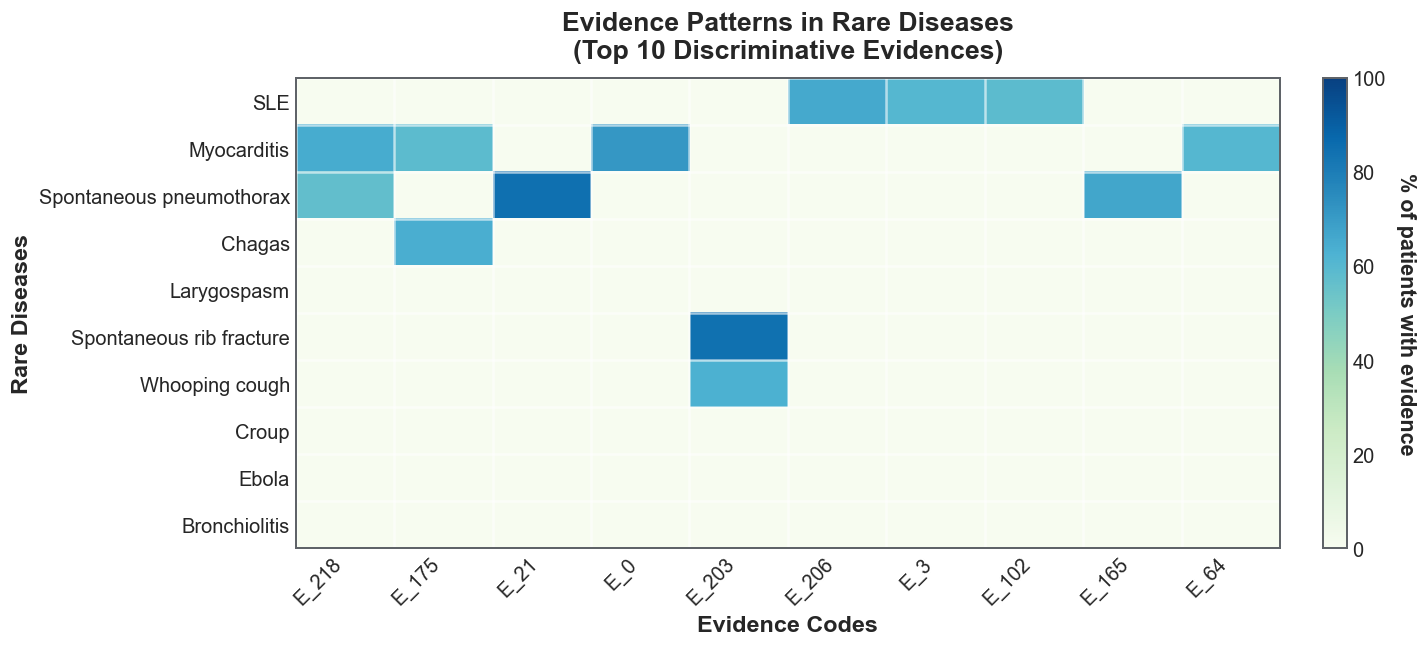

### Evidence Code Descriptions

*Top 10 most discriminative evidences for rare disease diagnosis (positive findings only)*

,Code,Description,Score
0,E_218,Do you have symptoms that are increased with physical exertion but alleviated with rest?,20.82x
1,E_175,"Have you noticed any new fatigue, generalized and vague discomfort, diffuse (widespread) muscle aches or a change in your general well-being related to your consultation today?",19.65x
2,E_21,Have you ever had a spontaneous pneumothorax?,13.82x
3,E_0,Have you recently had a viral infection?,12.72x
4,E_203,Do you have intense coughing fits?,12.61x
5,E_206,Do you have painful mouth ulcers or sores?,12.46x
6,E_3,Have you ever had a pericarditis?,11.48x
7,E_102,Are you consulting because you have high blood pressure?,11.08x
8,E_165,Have any of your family members ever had a pneumothorax?,10.86x
9,E_64,Do you feel out of breath with minimal physical effort?,10.79x



✓ 10 evidence codes displayed
✓ Figure optimized for slides (10×5.5)


In [74]:
# --- Visualization (slide-friendly size) ---
fig, ax = plt.subplots(figsize=(12, 5.5))  # Compact for slides

# Heatmap (GnBu colormap)
im = ax.imshow(presence_matrix, cmap='GnBu', aspect='auto', vmin=0, vmax=100)

ax.set_xticks(np.arange(len(top_evidences)))
ax.set_yticks(np.arange(len(rare_diseases_sorted)))

# Tick labels - regular weight, still readable
ax.set_xticklabels(top_evidences, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(rare_diseases_sorted, fontsize=12)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('% of patients with evidence', rotation=270, labelpad=18, 
               fontsize=13, weight='bold')
cbar.ax.tick_params(labelsize=12)

# Title and labels (bold for emphasis, but not too large)
ax.set_title('Evidence Patterns in Rare Diseases\n(Top 10 Discriminative Evidences)', 
             weight='bold', pad=12)
ax.set_xlabel('Evidence Codes', weight='bold')
ax.set_ylabel('Rare Diseases', weight='bold')

# Grid
ax.set_xticks(np.arange(len(top_evidences)) - 0.5, minor=True)
ax.set_yticks(np.arange(len(rare_diseases_sorted)) - 0.5, minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=1.5)

plt.tight_layout()
save_fig(fig, '08_rare_disease_evidence_heatmap.png')
plt.show()

# --- Evidence descriptions table ---
display(Markdown("### Evidence Code Descriptions"))
display(Markdown("*Top 10 most discriminative evidences for rare disease diagnosis (positive findings only)*"))

evidence_table = pd.DataFrame({
    'Code': top_evidences,
    'Description': [
        evidences.get(ev, {}).get('question_en', 'Unknown') 
        for ev in top_evidences
    ],
    'Score': [f"{score:.2f}x" for ev, score in top_discriminative[:10]]
})

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

display(evidence_table)

print(f"\n✓ {len(top_evidences)} evidence codes displayed")
print(f"✓ Figure optimized for slides (10×5.5)")

In [72]:
# Quick check
print(f"\n📊 Matrix Validation:")
print(f"   Mean presence: {presence_matrix.mean():.1f}%")
print(f"   Max presence: {presence_matrix.max():.1f}%")
print(f"   Values >90%: {(presence_matrix > 90).sum()} (should be few/none)")



📊 Matrix Validation:
   Mean presence: 8.6%
   Max presence: 84.5%
   Values >90%: 0 (should be few/none)


### Evidence Structure Summary

**Evidence Types:**
- **Binary (B):** 208 codes (93.3%) - Yes/No symptoms
- **Categorical (C):** 10 codes - Single choice with values
- **Multi-choice (M):** 5 codes - Multiple selections

**Evidence Categories:**
1. **Symptoms** (E_1-E_150): Patient complaints (fever, pain, cough)
2. **Physical findings** (E_151-E_200): Examination results (rash location, breath sounds)
3. **Demographics** (AGE, SEX): Patient characteristics
4. **Antecedents** (E_201-E_223): Medical history, risk factors

**Key Findings:**
- 223 evidence codes defined in mapping
- 223 codes actually used in dataset (100% coverage)
- Most symptoms are binary (presence/absence)
- 113 conditions are risk factors (antedecents), 110 are symptoms
- Categorical evidences need value decoding (e.g., pain location)

**Implications for Feature Engineering:**
- Antedecents may be important d´for rare disease detection    
- Binary evidnces: Direct one-hot encoding
- Categorical evidences: Need to parse `_@_V_xxx` suffixes
- Must decode evidence codes to human-readable names for interpretability


#### Data Structure

**Binary evidence:**  
E_91 → "Do you have a fever?"  
Values: 0 (no) or 1 (yes)  

**Categorical evidence:**
E_130 @ V_86 → "What color is the rash?" → "dark"
Format: code @ value_code

In [75]:
# ============================================================================
# Section 5.8 - DIFFERENTIAL DIAGNOSIS LIST LENGTH ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 5.8: DIFFERENTIAL DIAGNOSIS LIST LENGTH ANALYSIS")
print("="*80)

print("""
The differential diagnosis (DDX) list represents the ranked set of candidate
diseases considered for each patient. Understanding the distribution of list
lengths helps us design appropriate ranking models.
""")

# ============================================================================
# Create ddx_len feature
# ============================================================================

print("\n" + "-"*80)
print("5.8.1 - Computing Differential Diagnosis List Lengths")
print("-"*80)

df_all['ddx_len'] = df_all['DIFFERENTIAL_DIAGNOSIS_list'].apply(len)

print(f"✓ Created ddx_len column for {len(df_all):,} cases")

# Descriptive statistics
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)
print(df_all['ddx_len'].describe())

print(f"\nAdditional statistics:")
print(f"  Mode (most common):  {df_all['ddx_len'].mode()[0]}")
print(f"  Unique list lengths: {df_all['ddx_len'].nunique()}")
print(f"  Range:               {df_all['ddx_len'].min()} - {df_all['ddx_len'].max()}")

# Show frequency distribution
print("\n" + "-"*80)
print("Top 10 Most Common List Lengths:")
print("-"*80)
print(df_all['ddx_len'].value_counts().head(10))



SECTION 5.8: DIFFERENTIAL DIAGNOSIS LIST LENGTH ANALYSIS

The differential diagnosis (DDX) list represents the ranked set of candidate
diseases considered for each patient. Understanding the distribution of list
lengths helps us design appropriate ranking models.


--------------------------------------------------------------------------------
5.8.1 - Computing Differential Diagnosis List Lengths
--------------------------------------------------------------------------------
✓ Created ddx_len column for 1,278,666 cases

DESCRIPTIVE STATISTICS
count    1.278666e+06
mean     9.223112e+00
std      5.999765e+00
min      1.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.300000e+01
max      3.400000e+01
Name: ddx_len, dtype: float64

Additional statistics:
  Mode (most common):  3
  Unique list lengths: 34
  Range:               1 - 34

--------------------------------------------------------------------------------
Top 10 Most Common List Lengths:
----------------------


--------------------------------------------------------------------------------
5.8.2 - Creating Visualizations
--------------------------------------------------------------------------------


C:\Users\julia\AppData\Local\Temp\ipykernel_29144\411128772.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(


✓ Saved: figures\09_diagnoses_list_length_distribution.png


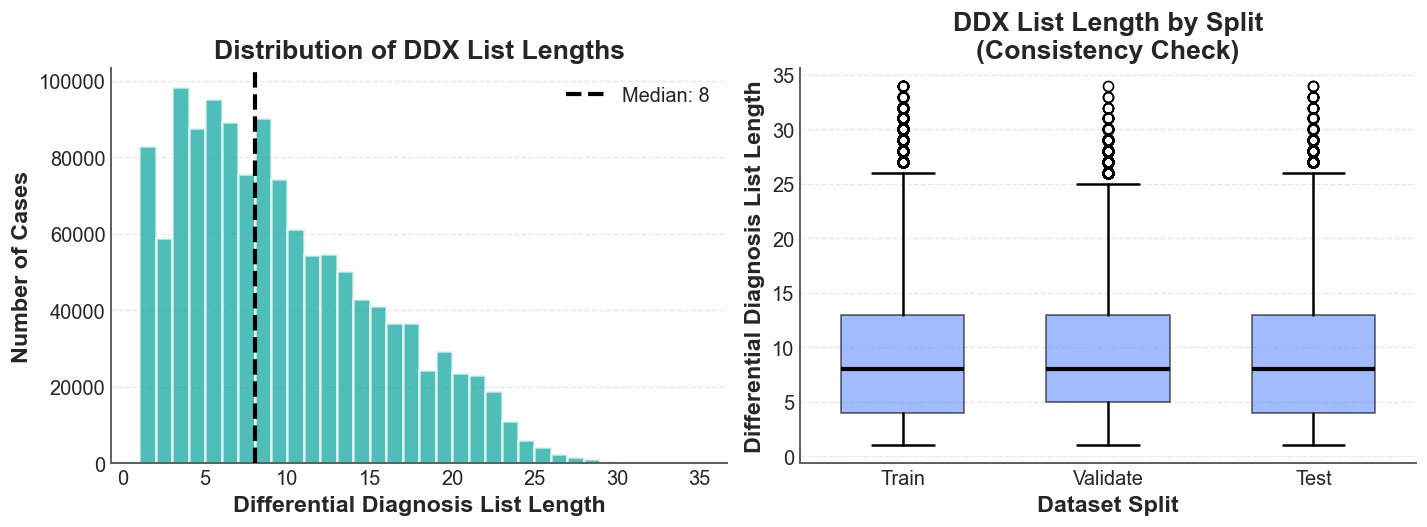

In [76]:
# ============================================================================
# Figure 9: Differential Diagnosis List Length Analysis
# ============================================================================

print("\n" + "-"*80)
print("5.8.2 - Creating Visualizations")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# === LEFT PLOT: Histogram with median only ===
ax1 = axes[0]

# Create histogram
counts, bins, patches = ax1.hist(
    df_all['ddx_len'], 
    bins=range(df_all['ddx_len'].min(), df_all['ddx_len'].max() + 2),
    color=IBM_COLORS['teal'], 
    alpha=0.7,
    edgecolor='white',
    linewidth=1.5
)

# Add median line only (more robust than mean)
median_val = df_all['ddx_len'].median()

ax1.axvline(median_val, color='black', linestyle='--', linewidth=2.5, 
            label=f'Median: {median_val:.0f}', zorder=3)

# Styling
ax1.set_xlabel('Differential Diagnosis List Length', weight='bold')
ax1.set_ylabel('Number of Cases', weight='bold')
ax1.set_title('Distribution of DDX List Lengths', weight='bold')
ax1.legend(loc='upper right')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', linestyle='--')

# === RIGHT PLOT: Box plot by split (no overall mean line) ===
ax2 = axes[1]

# Prepare data for box plot
split_data = [
    df_all[df_all['split'] == 'train']['ddx_len'],
    df_all[df_all['split'] == 'validate']['ddx_len'],
    df_all[df_all['split'] == 'test']['ddx_len']
]

bp = ax2.boxplot(
    split_data,
    labels=['Train', 'Validate', 'Test'],
    patch_artist=True,
    widths=0.6,
    medianprops=dict(color='black', linewidth=2.5),
    boxprops=dict(facecolor=IBM_COLORS['blue'], alpha=0.6),
    whiskerprops=dict(linewidth=1.5),
    capprops=dict(linewidth=1.5)
)

# Styling
ax2.set_ylabel('Differential Diagnosis List Length', weight='bold')
ax2.set_xlabel('Dataset Split', weight='bold')
ax2.set_title('DDX List Length by Split\n(Consistency Check)', weight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='y', linestyle='--')

plt.tight_layout()
save_fig(fig, '09_diagnoses_list_length_distribution.png')
plt.show()



--------------------------------------------------------------------------------
5.8.3 - DDX List Length by Disease
--------------------------------------------------------------------------------

Diseases with LONGEST average DDX lists (more differential options):
                                               mean       std  count
PATHOLOGY                                                           
Pneumonia                                 17.893464  5.603572  32787
Acute pulmonary edema                     17.552496  4.535933  24116
Bronchitis                                17.428840  6.734606  33537
Panic attack                              16.352748  4.924102  31643
Bronchospasm / acute asthma exacerbation  15.530431  5.512231  23200
Anaphylaxis                               15.095092  4.846358  35271
Unstable angina                           14.829897  5.311822  26872
Bronchiolitis                             14.630435  3.233885    322
Possible NSTEMI / STEMI                   

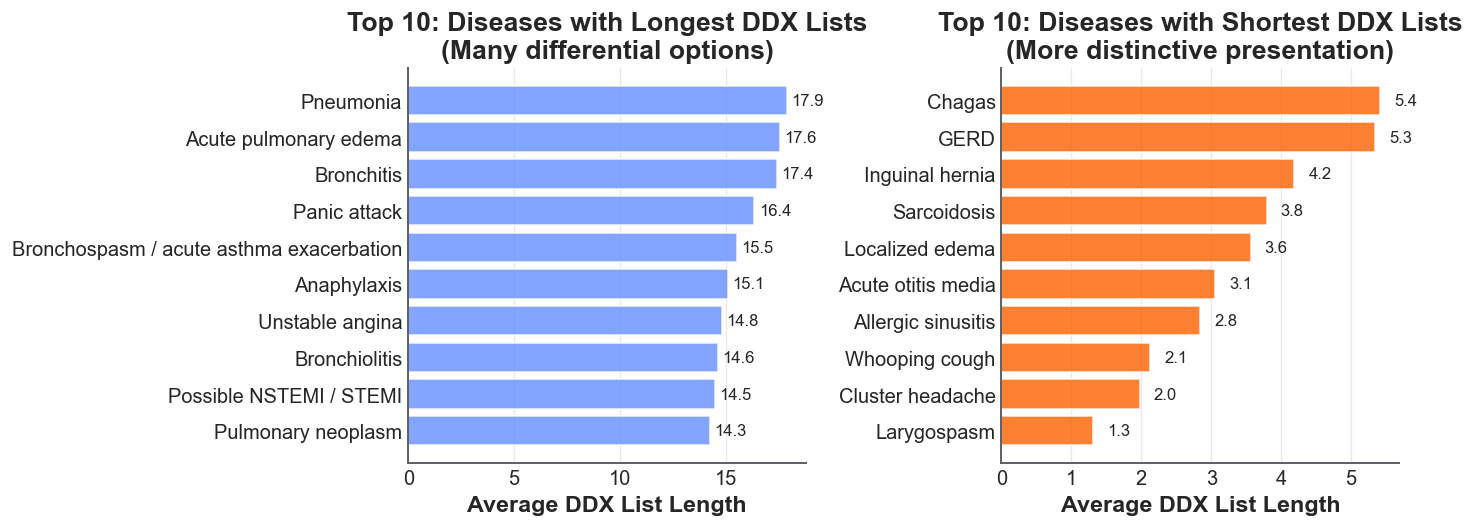

In [77]:
# ============================================================================
# Additional Analysis: DDX Length by Disease
# ============================================================================

print("\n" + "-"*80)
print("5.8.3 - DDX List Length by Disease")
print("-"*80)

# Calculate average DDX length per disease
ddx_by_disease = df_all.groupby('PATHOLOGY')['ddx_len'].agg(['mean', 'std', 'count'])
ddx_by_disease = ddx_by_disease.sort_values('mean', ascending=False)

print("\nDiseases with LONGEST average DDX lists (more differential options):")
print(ddx_by_disease.head(10).to_string())

print("\n" + "-"*80)
print("\nDiseases with SHORTEST average DDX lists (more distinctive):")
print(ddx_by_disease.tail(10).to_string())

# Visualization: Top/Bottom 10
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Top 10 diseases with longest DDX lists
ax1 = axes[0]
top_10 = ddx_by_disease.head(10)
bars1 = ax1.barh(range(len(top_10)), top_10['mean'], 
                 color=IBM_COLORS['blue'], alpha=0.8, edgecolor='white')
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels(top_10.index)
ax1.set_xlabel('Average DDX List Length', weight='bold')
ax1.set_title('Top 10: Diseases with Longest DDX Lists\n(Many differential options)', 
              weight='bold')
ax1.invert_yaxis()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='x')

# Add value labels
for i, (bar, value) in enumerate(zip(bars1, top_10['mean'])):
    ax1.text(value + 0.2, i, f'{value:.1f}', va='center', fontsize=10)

# Bottom 10 diseases with shortest DDX lists
ax2 = axes[1]
bottom_10 = ddx_by_disease.tail(10)
bars2 = ax2.barh(range(len(bottom_10)), bottom_10['mean'], 
                 color=IBM_COLORS['orange'], alpha=0.8, edgecolor='white')
ax2.set_yticks(range(len(bottom_10)))
ax2.set_yticklabels(bottom_10.index)
ax2.set_xlabel('Average DDX List Length', weight='bold')
ax2.set_title('Top 10: Diseases with Shortest DDX Lists\n(More distinctive presentation)', 
              weight='bold')
ax2.invert_yaxis()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='x')

# Add value labels
for i, (bar, value) in enumerate(zip(bars2, bottom_10['mean'])):
    ax2.text(value + 0.2, i, f'{value:.1f}', va='center', fontsize=10)

plt.tight_layout()
save_fig(fig, '10_ddx_length_by_disease.png')
plt.show()


In [78]:
# ============================================================================
# Section 5.9 - TOP EVIDENCE CODES ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 5.9: TOP EVIDENCE CODES ANALYSIS")
print("="*80)

print("""
Understanding which evidence codes (symptoms, findings, patient attributes)
appear most frequently helps us identify the most clinically relevant features
for diagnosis prediction. This analysis examines positive findings only,
excluding default values that represent absence or non-evaluation.
""")

# ============================================================================
# Step 1: Extract Effective Evidence Codes
# ============================================================================

print("\n" + "-"*80)
print("5.9.1 - Computing Evidence Frequencies (Positive Findings Only)")
print("-"*80)

# Create mapping: code → understandable description
evidence_name_map = {
    code: info['question_en'] 
    for code, info in evidences.items()
}

def get_evidence_name(code):
    """
    Get human-readable description for evidence code.
    Returns the code itself if description not found.
    """
    return evidence_name_map.get(code, code)

# Count EFFECTIVE base evidence codes across all patients
base_counter = Counter()

for ev_list in df_all["EVIDENCES_list"]:
    # Get unique base codes for EFFECTIVE evidences only (exclude defaults)
    base_codes = {
        to_base(code) for code in ev_list 
        if is_effective_item(code, evidences)  # ✅ Filter defaults
    }
    base_counter.update(base_codes)

print(f"✓ Analyzed evidence codes across {len(df_all):,} unique patients")
print(f"✓ Found {len(base_counter):,} unique evidence base codes (positive findings)")

# Get top 20
top20 = base_counter.most_common(20)
top_df = pd.DataFrame(top20, columns=["evidence_code", "patient_count"])

# Add human-readable descriptions
top_df['evidence_name'] = top_df['evidence_code'].apply(get_evidence_name)

# Calculate percentage
top_df['percentage'] = (top_df['patient_count'] / len(df_all)) * 100

# Re-order for readability
top_df = top_df[['evidence_code', 'evidence_name', 'patient_count', 'percentage']]

print("\n" + "="*80)
print("TOP 20 MOST COMMON EVIDENCE CODES (Positive Findings Only)")
print("="*80)
display(top_df)

# Summary statistics
print("\n" + "-"*80)
print("SUMMARY STATISTICS")
print("-"*80)
print(f"Most common evidence:      {top_df.iloc[0]['evidence_code']} "
      f"({top_df.iloc[0]['patient_count']:,} patients, {top_df.iloc[0]['percentage']:.1f}%)")
print(f"20th most common:          {top_df.iloc[19]['evidence_code']} "
      f"({top_df.iloc[19]['patient_count']:,} patients, {top_df.iloc[19]['percentage']:.1f}%)")
print(f"Mean frequency (top 20):   {top_df['patient_count'].mean():,.0f} patients")
print(f"Median frequency (top 20): {top_df['patient_count'].median():,.0f} patients")

print("\n✓ Analysis complete (default values excluded)")



SECTION 5.9: TOP EVIDENCE CODES ANALYSIS

Understanding which evidence codes (symptoms, findings, patient attributes)
appear most frequently helps us identify the most clinically relevant features
for diagnosis prediction. This analysis examines positive findings only,
excluding default values that represent absence or non-evaluation.


--------------------------------------------------------------------------------
5.9.1 - Computing Evidence Frequencies (Positive Findings Only)
--------------------------------------------------------------------------------
✓ Analyzed evidence codes across 1,278,666 unique patients
✓ Found 223 unique evidence base codes (positive findings)

TOP 20 MOST COMMON EVIDENCE CODES (Positive Findings Only)


,evidence_code,evidence_name,patient_count,percentage
0,E_58,How precisely is the pain located?,1013888,79.292638
1,E_59,How fast did the pain appear?,1013888,79.292638
2,E_56,How intense is the pain?,1013888,79.292638
3,E_55,Do you feel pain somewhere?,1000606,78.253899
4,E_54,Characterize your pain:,1000606,78.253899
5,E_53,"Do you have pain somewhere, related to your reason for consulting?",1000606,78.253899
6,E_66,Are you experiencing shortness of breath or difficulty breathing in a significant way?,499559,39.068764
7,E_201,Do you have a cough?,397961,31.123139
8,E_79,Do you smoke cigarettes?,360108,28.162788
9,E_57,Does the pain radiate to another location?,276420,21.617842



--------------------------------------------------------------------------------
SUMMARY STATISTICS
--------------------------------------------------------------------------------
Most common evidence:      E_58 (1,013,888 patients, 79.3%)
20th most common:          E_50 (163,694 patients, 12.8%)
Mean frequency (top 20):   491,530 patients
Median frequency (top 20): 275,178 patients

✓ Analysis complete (default values excluded)



--------------------------------------------------------------------------------
5.9.2 - Creating Visualization
--------------------------------------------------------------------------------
✓ Saved: figures\11_top20_evidence_codes.png


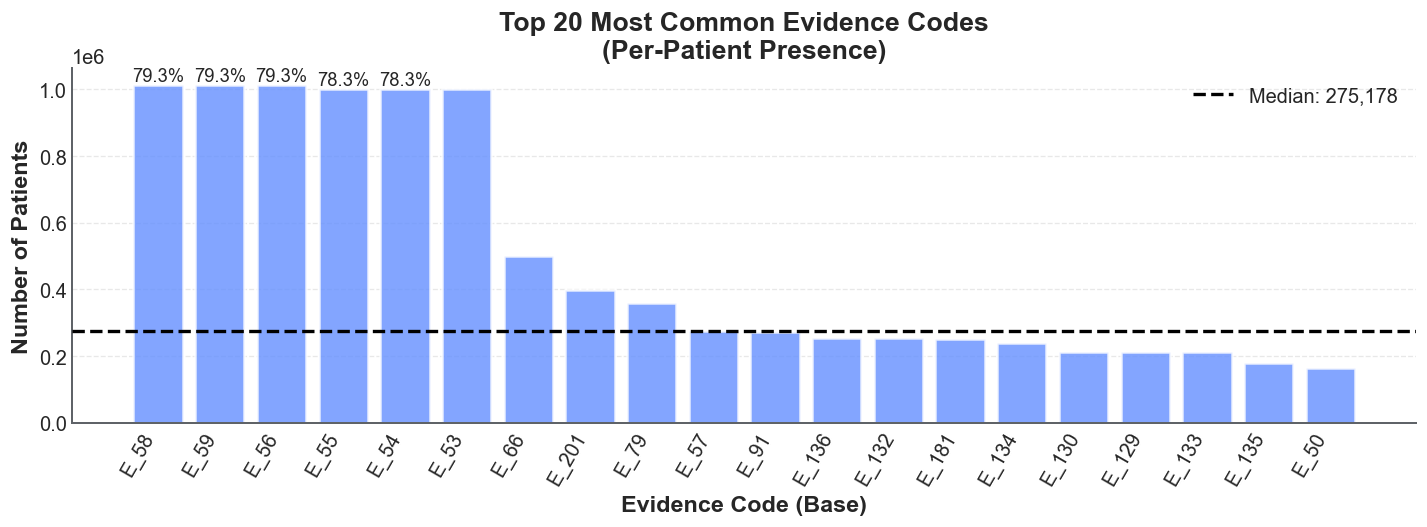

In [79]:
# ============================================================================
# Step 2: Visualization
# ============================================================================

print("\n" + "-"*80)
print("5.9.2 - Creating Visualization")
print("-"*80)

fig, ax = plt.subplots(figsize=(12, 4.5))

# Create bar chart
bars = ax.bar(
    range(len(top_df)), 
    top_df['patient_count'],
    color=IBM_COLORS['blue'],
    alpha=0.8,
    edgecolor='white',
    linewidth=1.5
)

# Add median reference line only
median_val = top_df['patient_count'].median()

ax.axhline(median_val, color='black', linestyle='--', linewidth=2, 
           label=f'Median: {median_val:,.0f}', zorder=3)

# Styling
ax.set_xticks(range(len(top_df)))
ax.set_xticklabels(top_df['evidence_code'], rotation=60, ha='right')
ax.set_xlabel('Evidence Code (Base)', weight='bold')
ax.set_ylabel('Number of Patients', weight='bold')
ax.set_title('Top 20 Most Common Evidence Codes\n(Per-Patient Presence)', 
             weight='bold')

# Add legend
ax.legend(loc='upper right')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grid
ax.grid(axis='y', linestyle='--')

# Add percentage labels on top of bars (only for top 5)
for i in range(min(5, len(bars))):
    height = bars[i].get_height()
    pct = top_df.iloc[i]['percentage']
    ax.text(bars[i].get_x() + bars[i].get_width()/2., height,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=11)

plt.tight_layout()
save_fig(fig, '11_top20_evidence_codes.png')
plt.show()


In [80]:
# ============================================================================
# Step 3: Symptom Coverage Analysis (Binary Evidences Only)
# ============================================================================

print("\n" + "-"*80)
print("5.9.3 - Symptom Coverage Analysis (Positive Findings Only)")
print("-"*80)

# Filter to binary evidences only
binary_evidence_codes = {
    code for code, info in evidences.items()
    if info['data_type'] == 'B'
}

top20_binary = [
    code for code in top_df['evidence_code'].values
    if code in binary_evidence_codes
][:20]

print(f"\nTop 20 includes {len(top20_binary)} binary evidences (actual symptoms)")

# Filter defaults in coverage calculation
patients_with_top20_symptoms = sum(
    1 for ev_list in df_all["EVIDENCES_list"]
    if any(
        split_ev(code)[0] in top20_binary 
        and is_effective_item(code, evidences)  # ✅ Filter defaults
        for code in ev_list
    )
)

symptom_coverage_pct = (patients_with_top20_symptoms / len(df_all)) * 100

print(f"\nSymptom Coverage (Positive Findings Only):")
print(f"  Patients with at least one top-20 symptom: {patients_with_top20_symptoms:,}")
print(f"  Coverage: {symptom_coverage_pct:.1f}%")

# Filter defaults in average calculation
total_top20_symptoms = sum(
    sum(
        1 for code in ev_list 
        if split_ev(code)[0] in top20_binary 
        and is_effective_item(code, evidences)  # ✅ Filter defaults
    )
    for ev_list in df_all["EVIDENCES_list"]
)

avg_symptoms = total_top20_symptoms / len(df_all)
print(f"  Average top-20 symptoms per patient: {avg_symptoms:.2f}")


--------------------------------------------------------------------------------
5.9.3 - Symptom Coverage Analysis (Positive Findings Only)
--------------------------------------------------------------------------------

Top 20 includes 8 binary evidences (actual symptoms)

Symptom Coverage (Positive Findings Only):
  Patients with at least one top-20 symptom: 1,227,213
  Coverage: 96.0%
  Average top-20 symptoms per patient: 2.47


## 6. FINAL SUMMARY AND KEY INSIGHTS


In [81]:
# ============================================================================
# 6.1 - Compute Summary Statistics
# ============================================================================

print("\n" + "="*70)
print("6.1 - COMPUTING SUMMARY STATISTICS")
print("="*70)


# --- 1) Dataset overview ---
total_patients = len(df_all)
total_pathologies = df_all['PATHOLOGY'].nunique()
total_evidences = len(evidences)

split_counts = df_raw['split'].value_counts()
train_size = split_counts.get('train', 0)
val_size = split_counts.get('validate', 0)
test_size = split_counts.get('test', 0)

# --- 2) Demographics ---
gender_counts = df_all['SEX'].value_counts()
age_stats = df_all['AGE'].describe()

# --- 3) Disease distribution ---
disease_counts = df_all['PATHOLOGY'].value_counts()
top10_coverage = (disease_counts.head(10).sum() / len(df_all) * 100)
bottom10_coverage = (disease_counts.tail(10).sum() / len(df_all) * 100)
imbalance_ratio = disease_counts.iloc[0] / disease_counts.iloc[-1]

# --- 4) Evidence statistics ---
evidence_stats = df_all['num_evidences_effective'].describe()

# Evidence type distribution from mapping
type_counts = pd.Series([v.get("data_type", "UNK") for v in evidences.values()]).value_counts()
binary_count = type_counts.get("B", 0)
categorical_count = type_counts.get("C", 0)
multi_count = type_counts.get("M", 0)

# Symptoms vs antecedents
symptom_count = sum(1 for v in evidences.values() if v.get("is_antecedent") == False)
antecedent_count = sum(1 for v in evidences.values() if v.get("is_antecedent") == True)

# --- 5) DDX statistics ---
ddx_stats = df_all['ddx_len'].describe()

print("✓ Statistics computed")



6.1 - COMPUTING SUMMARY STATISTICS
✓ Statistics computed


In [82]:
# ============================================================================
# 6.2 - Create Comprehensive Summary Table
# ============================================================================

print("\n" + "="*70)
print("6.2 - CREATING SUMMARY TABLE")
print("="*70)

summary_data = {
    'Metric': [
        # Dataset Overview
        'Total Patients',
        'Total Pathologies',
        'Total Evidence Codes',
        'Train Set',
        'Validation Set',
        'Test Set',
        # Demographics
        'Gender - Male',
        'Gender - Female',
        'Age Range',
        'Age Mean (SD)',
        'Age Median',
        # Disease Distribution
        'Most Common Disease',
        'Least Common Disease',
        'Top 10 Coverage',
        'Bottom 10 Coverage',
        'Class Imbalance Ratio',
        # Evidence Statistics
        'Avg Evidences per Patient',
        'Evidence Range',
        'Binary Evidence Codes',
        'Categorical Evidence Codes',
        'Multi-choice Evidence Codes',
        'Symptoms',
        'Antecedents',
        # DDX Statistics
        'Avg DDX List Length',
        'DDX Range',
    ],
    'Value': [
        f"{total_patients:,}",
        f"{total_pathologies}",
        f"{total_evidences}",
        f"{train_size:,} ({train_size/total_patients*100:.1f}%)",
        f"{val_size:,} ({val_size/total_patients*100:.1f}%)",
        f"{test_size:,} ({test_size/total_patients*100:.1f}%)",
        f"{gender_counts.get('M', 0):,} ({gender_counts.get('M', 0)/total_patients*100:.1f}%)",
        f"{gender_counts.get('F', 0):,} ({gender_counts.get('F', 0)/total_patients*100:.1f}%)",
        f"{int(age_stats['min'])}-{int(age_stats['max'])} years",
        f"{age_stats['mean']:.1f} ± {age_stats['std']:.1f} years",
        f"{age_stats['50%']:.1f} years",
        f"{disease_counts.index[0]} ({disease_counts.iloc[0]:,} cases)",
        f"{disease_counts.index[-1]} ({disease_counts.iloc[-1]:,} cases)",
        f"{top10_coverage:.1f}%",
        f"{bottom10_coverage:.1f}%",
        f"1:{imbalance_ratio:.1f}",
        f"{evidence_stats['mean']:.1f}",
        f"{int(evidence_stats['min'])}-{int(evidence_stats['max'])}",
        f"{binary_count} ({binary_count/total_evidences*100:.1f}%)",
        f"{categorical_count} ({categorical_count/total_evidences*100:.1f}%)",
        f"{multi_count} ({multi_count/total_evidences*100:.1f}%)",
        f"{symptom_count} ({symptom_count/total_evidences*100:.1f}%)",
        f"{antecedent_count} ({antecedent_count/total_evidences*100:.1f}%)",
        f"{ddx_stats['mean']:.1f}",
        f"{int(ddx_stats['min'])}-{int(ddx_stats['max'])}",
    ]
}

df_summary = pd.DataFrame(summary_data)

print("\n" + df_summary.to_string(index=False))
print("\n✓ Summary table created")



6.2 - CREATING SUMMARY TABLE

                     Metric                     Value
             Total Patients                 1,278,666
          Total Pathologies                        49
       Total Evidence Codes                       223
                  Train Set         1,025,602 (80.2%)
             Validation Set           132,448 (10.4%)
                   Test Set           134,529 (10.5%)
              Gender - Male           620,614 (48.5%)
            Gender - Female           658,052 (51.5%)
                  Age Range               0-109 years
              Age Mean (SD)         39.8 ± 22.7 years
                 Age Median                39.0 years
        Most Common Disease       URTI (81,767 cases)
       Least Common Disease Bronchiolitis (322 cases)
            Top 10 Coverage                     36.5%
         Bottom 10 Coverage                      6.2%
      Class Imbalance Ratio                   1:253.9
  Avg Evidences per Patient                      13

In [83]:
# ============================================================================
# 6.3 - Key Findings and Insights
# ============================================================================

print("\n" + "="*70)
print("6.3 - KEY FINDINGS AND INSIGHTS")
print("="*70)

findings = f"""

1. DATASET QUALITY & STRUCTURE
   ✓ Well-balanced synthetic dataset with {total_patients:,} unique patient patterns
   ✓ Clean data with no missing values or data quality issues
   ✓ Proper train/validation/test split: {train_size:,}/{val_size:,}/{test_size:,}
   ✓ Comprehensive coverage: {total_evidences} evidence codes across {total_pathologies} diseases

2. DEMOGRAPHIC PATTERNS
   ✓ Balanced gender distribution: {gender_counts.get('M', 0)/total_patients*100:.1f}% male, {gender_counts.get('F', 0)/total_patients*100:.1f}% female
   ✓ Wide age range ({int(age_stats['min'])}-{int(age_stats['max'])} years) with mean {age_stats['mean']:.1f} years
   ✓ Age distribution appropriate for disease patterns
   ✓ Continuous age variable allows flexible modeling

3. DISEASE DISTRIBUTION INSIGHTS
   ✓ Significant class imbalance: 1:{imbalance_ratio:.1f} ratio (most to least common)
   ✓ Top 10 diseases account for {top10_coverage:.1f}% of all cases
   ✓ Bottom 10 rare diseases represent only {bottom10_coverage:.1f}% of cases
   ✓ Challenge: Rare disease detection requires specialized approach
   ✓ Most common: {disease_counts.index[0]} ({disease_counts.iloc[0]:,} cases)
   ✓ Least common: {disease_counts.index[-1]} ({disease_counts.iloc[-1]:,} cases)

4. EVIDENCE PATTERNS
   ✓ Average {evidence_stats['mean']:.1f} evidences per patient
   ✓ Evidence range: {int(evidence_stats['min'])}-{int(evidence_stats['max'])} per patient
   ✓ {binary_count/total_evidences*100:.1f}% binary evidences (yes/no) - dominant type
   ✓ {categorical_count/total_evidences*100:.1f}% categorical evidences (multi-value)
   ✓ {multi_count/total_evidences*100:.1f}% multi-choice evidences (can select multiple)
   ✓ {symptom_count/total_evidences*100:.1f}% symptoms vs {antecedent_count/total_evidences*100:.1f}% antecedents
   ✓ Median DDX list length: {ddx_stats['50%']:.0f} diagnoses per patient

5. DATA PROCESSING INSIGHTS
   ✓ Deduplication reduced dataset from {len(df_raw):,} to {len(df_all):,} rows
   ✓ Frequency column preserved for proper weighting
   ✓ Evidence codes standardized (base codes extracted)
   ✓ Multi-choice evidences properly handled

6. MODELING IMPLICATIONS
   ✓ Class imbalance requires weighting or sampling strategies
   ✓ Binary evidence dominance suggests simple encoding strategies
   ✓ Differential diagnosis lists enable ranking evaluation
   ✓ High-dimensional feature space ({total_evidences} evidence codes)
   ✓ Opportunity for hierarchical modeling (common → rare diseases)

"""

print(findings)



6.3 - KEY FINDINGS AND INSIGHTS


1. DATASET QUALITY & STRUCTURE
   ✓ Well-balanced synthetic dataset with 1,278,666 unique patient patterns
   ✓ Clean data with no missing values or data quality issues
   ✓ Proper train/validation/test split: 1,025,602/132,448/134,529
   ✓ Comprehensive coverage: 223 evidence codes across 49 diseases

2. DEMOGRAPHIC PATTERNS
   ✓ Balanced gender distribution: 48.5% male, 51.5% female
   ✓ Wide age range (0-109 years) with mean 39.8 years
   ✓ Age distribution appropriate for disease patterns
   ✓ Continuous age variable allows flexible modeling

3. DISEASE DISTRIBUTION INSIGHTS
   ✓ Significant class imbalance: 1:253.9 ratio (most to least common)
   ✓ Top 10 diseases account for 36.5% of all cases
   ✓ Bottom 10 rare diseases represent only 6.2% of cases
   ✓ Challenge: Rare disease detection requires specialized approach
   ✓ Most common: URTI (81,767 cases)
   ✓ Least common: Bronchiolitis (322 cases)

4. EVIDENCE PATTERNS
   ✓ Average 13.6 eviden

In [84]:
# ============================================================================
# 6.4 - Create Detailed Analysis Tables
# ============================================================================

print("\n" + "="*70)
print("6.4 - CREATING DETAILED TABLES")
print("="*70)

# --- 1) Split distribution ---
tbl_split = (
    df_raw["split"].value_counts()
    .rename_axis("split").reset_index(name="count")
)
tbl_split["percent"] = (tbl_split["count"] / tbl_split["count"].sum() * 100).round(2)

# --- 2) Pathology distribution ---
tbl_pathology = (
    df_all["PATHOLOGY"].value_counts()
    .rename_axis("pathology").reset_index(name="count")
)
tbl_pathology["percent"] = (tbl_pathology["count"] / tbl_pathology["count"].sum() * 100).round(2)

# --- 3) Evidence type distribution ---
tbl_evidence_types = pd.DataFrame({
    "evidence_type": ["Binary", "Categorical", "Multi-choice"],
    "code": ["B", "C", "M"],
    "count": [binary_count, categorical_count, multi_count]
})
tbl_evidence_types["percent"] = (tbl_evidence_types["count"] / total_evidences * 100).round(2)

# --- 4) Symptom vs antecedent ---
tbl_symptom_antecedent = pd.DataFrame({
    "category": ["Symptoms", "Antecedents"],
    "count": [symptom_count, antecedent_count]
})
tbl_symptom_antecedent["percent"] = (tbl_symptom_antecedent["count"] / total_evidences * 100).round(2)

# --- 5) Evidence count statistics ---
tbl_evidence_stats = df_all[["num_evidences_effective"]].describe().T  # ✅ Changed
tbl_evidence_stats = tbl_evidence_stats.reset_index()
tbl_evidence_stats.columns = ['metric'] + list(tbl_evidence_stats.columns[1:])

# --- 6) DDX length statistics ---
tbl_ddx_stats = df_all[["ddx_len"]].describe().T
tbl_ddx_stats = tbl_ddx_stats.reset_index()
tbl_ddx_stats.columns = ['metric'] + list(tbl_ddx_stats.columns[1:])

# --- 7) Top 20 evidences (positive findings only) ---
base_counter = Counter()
for ev_list in df_all["EVIDENCES_list"]:
    base_counter.update({
        to_base(c) for c in ev_list 
        if is_effective_item(c, evidences)  # ✅ Added filter
    })

top20 = base_counter.most_common(20)
tbl_top_evidences = pd.DataFrame(top20, columns=["evidence_code", "patient_count"])
tbl_top_evidences["question"] = tbl_top_evidences["evidence_code"].apply(
    lambda c: evidences.get(c, {}).get("question_en", "UNKNOWN")
)
tbl_top_evidences["percent_patients"] = (tbl_top_evidences["patient_count"] / len(df_all) * 100).round(2)

# --- 8) Frequency distribution (from deduplication) ---
if 'frequency' in df_raw.columns:
    tbl_frequency = (
        df_raw["frequency"].value_counts()
        .sort_index()
        .rename_axis("frequency").reset_index(name="pattern_count")
    )
    tbl_frequency["percent"] = (tbl_frequency["pattern_count"] / len(df_raw) * 100).round(2)
else:
    tbl_frequency = pd.DataFrame({
        "frequency": [1],
        "pattern_count": [len(df_raw)],
        "percent": [100.0]
    })

# Store tables in dictionary
tables = {
    "01_split_distribution": tbl_split,
    "02_pathology_distribution": tbl_pathology,
    "03_evidence_types": tbl_evidence_types,
    "04_symptom_vs_antecedent": tbl_symptom_antecedent,
    "05_evidence_count_stats": tbl_evidence_stats,
    "06_ddx_length_stats": tbl_ddx_stats,
    "07_top20_evidences": tbl_top_evidences,
    "08_frequency_distribution": tbl_frequency
}

print(f"✓ Created {len(tables)} detailed tables (defaults excluded from evidence-based tables)")



6.4 - CREATING DETAILED TABLES
✓ Created 8 detailed tables (defaults excluded from evidence-based tables)


In [85]:
# ============================================================================
# 6.5 - Save Summary Outputs
# ============================================================================

print("\n" + "="*70)
print("6.5 - SAVING SUMMARY OUTPUTS")
print("="*70)

# Create output directory
output_dir = Path("outputs")

# --- 1) Save main summary table as CSV ---
summary_csv = output_dir / "01_eda_summary.csv"
df_summary.to_csv(summary_csv, index=False)
print(f"✓ Saved: {summary_csv}")

# --- 2) Save all detailed tables as Excel workbook ---
excel_path = output_dir / "02_eda_detailed_tables.xlsx"
with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    for name, df in tables.items():
        sheet_name = name[:31]  # Excel sheet name limit
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✓ Saved: {excel_path} ({len(tables)} sheets)")

# --- 3) Save key statistics as JSON ---
stats_json = {
    "dataset_overview": {
        "total_patients": int(total_patients),
        "total_pathologies": int(total_pathologies),
        "total_evidences": int(total_evidences),
        "train_size": int(train_size),
        "validation_size": int(val_size),
        "test_size": int(test_size)
    },
    "demographics": {
        "male_count": int(gender_counts.get('M', 0)),
        "female_count": int(gender_counts.get('F', 0)),
        "age_min": int(age_stats['min']),
        "age_max": int(age_stats['max']),
        "age_mean": round(float(age_stats['mean']), 2),
        "age_std": round(float(age_stats['std']), 2),
        "age_median": round(float(age_stats['50%']), 2)
    },
    "disease_distribution": {
        "most_common": disease_counts.index[0],
        "most_common_count": int(disease_counts.iloc[0]),
        "least_common": disease_counts.index[-1],
        "least_common_count": int(disease_counts.iloc[-1]),
        "imbalance_ratio": round(float(imbalance_ratio), 2),
        "top10_coverage_pct": round(float(top10_coverage), 2),
        "bottom10_coverage_pct": round(float(bottom10_coverage), 2)
    },
    "evidence_statistics": {
        "avg_per_patient": round(float(evidence_stats['mean']), 2),
        "min_per_patient": int(evidence_stats['min']),
        "max_per_patient": int(evidence_stats['max']),
        "median_per_patient": round(float(evidence_stats['50%']), 2),
        "binary_count": int(binary_count),
        "categorical_count": int(categorical_count),
        "multi_count": int(multi_count),
        "symptom_count": int(symptom_count),
        "antecedent_count": int(antecedent_count)
    },
    "ddx_statistics": {
        "avg_length": round(float(ddx_stats['mean']), 2),
        "median_length": round(float(ddx_stats['50%']), 2),
        "min_length": int(ddx_stats['min']),
        "max_length": int(ddx_stats['max'])
    }
}

json_path = output_dir / "03_eda_statistics.json"
with open(json_path, 'w') as f:
    json.dump(stats_json, f, indent=2)

print(f"✓ Saved: {json_path}")

print("\n" + "="*70)
print("✅ SECTION 6 COMPLETE - ALL OUTPUTS SAVED")
print("="*70)



6.5 - SAVING SUMMARY OUTPUTS
✓ Saved: outputs\01_eda_summary.csv
✓ Saved: outputs\02_eda_detailed_tables.xlsx (8 sheets)
✓ Saved: outputs\03_eda_statistics.json

✅ SECTION 6 COMPLETE - ALL OUTPUTS SAVED
